In [1]:
%load_ext line_profiler

In [2]:
from IPython.core.display import display, HTML
#display(HTML('<style>.container {width:100% !important;} <\style>'))

In [3]:
from trivariatevectorlinearinterpolation import LinearAimAssister, LinearEigenvectorInterpolator, Dp87Linear

In [4]:
from auxiliarypointstuff import cy_compute_pos_aim, cy_cross_product, \
                                cy_in_plane, cy_orthogonal_component, \
                                cy_parallel_component, cy_normalize, \
                                cy_norm2, cy_min, cy_max, cy_dot

In [5]:
from ndcurvebsplineinterp import NDCurveBSplineInterpolator # <= Krever Fortran-Python-kobling

In [6]:
from trivariatevectorbsplineinterpolation import SplineAimAssister, SplineEigenvectorInterpolator, Dp87BSpline
# ^ Krever Fortran-Python-kobling

In [7]:
from analytical_field import AnalyticalAimAssister, Dp87Analytical, SinusoidalField, SphericalField

In [8]:
from trivariatescalarinterpolation import TrivariateSpline
# ^ Krever Fortan-Python-kobling

In [9]:
from triangleintersectioncheck import Triangle3D, MollerTrumboreChecker
# ^ Sjekk for triangulerings-intersections

In [10]:
import sys
sys.path.insert(0,'../..') # Sett inn det som trengs for at numerical_integrators
                           # blir tilgjengelig i path

In [11]:
from numerical_integrators.singlestep import rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkdp54,rkdp87

In [12]:
import multiprocessing as mp
import numpy as np
import numba as nb
import copy
import math
import time

In [13]:
import matplotlib as mpl
from matplotlib import tri as mtri
mpl.use("pgf")

from matplotlib import pyplot as plt
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [14]:
class VariationalRHS:
    """A wrapper class for the two (implemented) choices of kinds of ABC flow,
    namely stationary or time-aperiodic flow.
    
    Methods defined here:
    VariationalRHS.__init__(aperiodic)
    VariationalRHS.__call__(t,x)
    
    """
    def __init__(self, aperiodic):
        """VariationalRHS.__init__(aperiodic)
        
        param: aperiodic -- Boolean flag indicating whether or not
                            aperiodic flow is to be considered.
        
        If not aperiodic: A = A0 = sqrt(3)
                          B = B0 = sqrt(2)
                          C = C0 = 1
        If aperiodic:     A = A0 
                          B = B0*(1+k0*tanh(k1*t)*cos((k2*t)**2))
                          C = C0*(1+k0*tanh(k1*t)*sin((k3*t)**2))
        
        with k0 = 0.3, k1 = 0.5, k2 = 1.5 and k3 = 1.8,
        which are the parameters used in Oettinger & Haller (2016).
        """
        self.k0 = 0.3
        self.k1 = 0.5
        self.k2 = 1.5
        self.k3 = 1.8
        self.A = np.sqrt(3)
        self.B = np.sqrt(2)
        self.C = 1
        
        self._a = lambda t: self.A
        
        if aperiodic:
            self._b = lambda t: self.B*(1 + self.k0 * np.tanh(self.k1*t)*np.cos((self.k2*t)**2))
            self._c = lambda t: self.C*(1 + self.k0 * np.tanh(self.k1*t)*np.sin((self.k3*t)**2))
        else:
            self._b = lambda t: self.B
            self._c = lambda t: self.C
            
    def __call__(self,t,x):
        """A function which computes the right hand side(s) of the coupled equation of variations
        for the flow map Jacobian, for steady ABC flow.

        param: t -- Time
        param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                    Shape: (12,nx,ny,nz)
        OPTIONAL:
        param: A -- Default: A = sqrt(3)
        param: B -- Default: B = sqrt(2)
        param: C -- Default: C = 1

        return: Twelve-component array, containing the (component-wise) right hand side of the
                coupled equation of variations
                Shape: (12,nx,ny,nz)
        """
        ret = np.empty(x.shape)                                                 
        ret[0] = self._a(t)*np.sin(x[2]) + self._c(t)*np.cos(x[1])                # x-component of velocity field
        ret[1] = self._b(t)*np.sin(x[0]) + self._a(t)*np.cos(x[2])                # y-component of velocity field
        ret[2] = self._c(t)*np.sin(x[1]) + self._b(t)*np.cos(x[0])                # z-component of velocity field
        ret[3] = -self._c(t)*np.sin(x[1])*x[6] + self._a(t)*np.cos(x[2])*x[9]     # The remaining (coupled) entries
        ret[4] = -self._c(t)*np.sin(x[1])*x[7] + self._a(t)*np.cos(x[2])*x[10]    # constitute the RHS of the
        ret[5] = -self._c(t)*np.sin(x[1])*x[8] + self._a(t)*np.cos(x[2])*x[11]    # variational ODE for the
        ret[6] = self._b(t)*np.cos(x[0])*x[3] + -self._c(t)*np.sin(x[2])*x[9]     # flow map Jacobian
        ret[7] = self._b(t)*np.cos(x[0])*x[4] + -self._c(t)*np.sin(x[2])*x[10]  
        ret[8] = self._b(t)*np.cos(x[0])*x[5] + -self._c(t)*np.sin(x[2])*x[11]  
        ret[9] = -self._b(t)*np.sin(x[0])*x[3] + self._c(t)*np.cos(x[1])*x[6]   
        ret[10] = -self._b(t)*np.sin(x[0])*x[4] + self._c(t)*np.cos(x[1])*x[7]  
        ret[11] = -self._b(t)*np.sin(x[0])*x[5] + self._c(t)*np.cos(x[1])*x[8]  

        return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,integ,aperiodic,nproc=4):
    """A function which computes the eigenvalues and -vectors for the Cauchy-Green 
    strain tensor for a given velocity field in a given time interval, on a 
    regular Cartesian grid.
    
    param: t0 -- Start time
    param: x  -- (NumPy) array of abscissae values along the x-axis, i.e., 
                 the x-values of the points in the computational grid.
    param: y  -- (NumPy) array of abscissae values along the y-axis, i.e., 
                 the y-values of the points in the computational grid.
    param: z  -- (NumPy) array of abscissae values along the z-axis, i.e., 
                 the z-values of the points in the computational grid.
    param: tf -- End time
    param: h  -- (Initial) integration time step
    param: func -- Function handle, pointing to function returning the RHS
                   of the flow ODE system
    param: integ -- Function handle, pointing to function which performs
                    numerical integration (e.g., a Runge-Kutta solver)
    param: aperiodic -- Boolean flag, indicating whether or not the ABC
                        flow should be time-aperiodic.
                        In either case, the same parameter values
                        are used, as the ones found in 
                        Oettinger & Haller (2016).
    OPTIONAL:
    param: nproc -- The number of available cores for multiprocessing. 
                    Default: nproc=4
    
    return: lambdas -- 3-tuple of computed strain eigenvalues.
                       Sorted in ascending order. 
    return: xis     -- 3-tuple of computed (normalized) strain
                       eigenvectors. Sorted in the same order
                       as the eigenvalues.
                       
    """
    
    f = VariationalRHS(aperiodic)
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,f,integ,nproc)
    u, s, v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (np.ascontiguousarray(lm1), np.ascontiguousarray(lm2), np.ascontiguousarray(lm3)), \
            (np.ascontiguousarray(xi1), np.ascontiguousarray(xi2), np.ascontiguousarray(xi3))
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    """A function which computes the final state of the flow map Jacobian for three-dimensional
    tracer advection.
    
    param: t0 -- Start time
    param: x  -- (NumPy) array of abscissae values along the x-axis, i.e., 
                 the x-values of the points in the computational grid.
    param: y  -- (NumPy) array of abscissae values along the y-axis, i.e., 
                 the y-values of the points in the computational grid.
    param: z  -- (NumPy) array of abscissae values along the z-axis, i.e., 
                 the z-values of the points in the computational grid.
    param: tf -- End time
    param: h  -- (Initial) integration time step
    param: func -- Function handle, pointing to function returning the RHS
                   of the flow ODE system
    param: integ -- Function handle, pointing to function which performs
                    numerical integration (e.g., a Runge-Kutta solver)
    param: nproc -- The number of available cores for multiprocessing. 
    
    return: jac -- (NumPy) array of final state Jacobian values, with shape
                   (nx,ny,nz,3,3)
                   
    """
                                                                     
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j])
                    )
          for j in range(nproc)
         ]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    """A function which advects a slice of initial conditions from the initial 
    to the final state.
    
    param: t0 -- Start time
    param: pos -- (NumPy) array of initial conditions.
    param: tf -- End time
    param: h -- (Initial) integration step
    param: func -- Function handle, pointing to a function returning
                   the RHS of the flow ODE system
    param: integ -- Function handle, pointing to a function which
                    performs numerical integration (e.g., a Runge-Kutta solver)
    param: q -- Multiprocessing.Queue instance, in which the result is put.
    """
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [15]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87
aperiodic = True # <= Time-aperiodic ABC flow

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [16]:
recompute = False

In [17]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:
if recompute:
    (lm1,lm2,lm3), (xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,flowmap_integrator,aperiodic)
    np.save('lm1.npy',lm1)
    np.save('lm2.npy',lm2)
    np.save('lm3.npy',lm3)
    np.save('xi1.npy',xi1)
    np.save('xi2.npy',xi2)
    np.save('xi3.npy',xi3)
else:
    lm1 = np.load('lm1.npy')
    lm2 = np.load('lm2.npy')
    lm3 = np.load('lm3.npy')
    xi1 = np.load('xi1.npy')
    xi2 = np.load('xi2.npy')
    xi3 = np.load('xi3.npy')

In [18]:
# Conceptual illustration of how to compute an AB subdomain of the original grid.
# Not currently used. 

#def find_points_in_ab(hess_lm3,lm3,lm2,xi3):
#    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
#    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
#    return np.logical_and(mask_a,mask_b)

In [19]:
# Currently not used - kept for future reference wrt parameters etc
#hlm3 = compute_hessian_lm(lm3,x,y,z)
#ask_ab = find_points_in_ab(hlm3,lm3,lm2,xi3)

In [20]:
# Make interpolation objects of lambda 1 through to 3
# Use at least fourth order in order to enforce all second derivatives to be continuous
lm1_itp = TrivariateSpline(x,y,z,lm1,kx=4,ky=4,kz=4,extrap=False)
lm2_itp = TrivariateSpline(x,y,z,lm2,kx=4,ky=4,kz=4,extrap=False)
lm3_itp = TrivariateSpline(x,y,z,lm3,kx=4,ky=4,kz=4,extrap=False)

In [21]:
lm3_field = lm3_itp

In [22]:
linear_itp = not True # <= Må være True så lenge Fortran-Python-kobling ikke er på plass

In [23]:
if linear_itp:
    #xi1_itp = LinearEigenvectorInterpolator(x,y,z,xi1)
    #xi2_itp = LinearEigenvectorInterpolator(x,y,z,xi2)
    xi3_field = LinearEigenvectorInterpolator(x,y,z,xi3)
    direction_generator = LinearAimAssister(xi3_field)
    #strain_integrator = Dp54Linear(atol = 1e-4, rtol = 1e-4)
    #strain_integrator = Bs32Linear(atol = 1e-4, rtol = 1e-4)
    #strain_integrator = Bs32Linear(atol = 1e-4, rtol = 1e-4)
    strain_integrator = Dp87Linear(atol = 1e-6, rtol = 1e-6)
else:
    #xi1_itp = SplineEigenvectorInterpolator(x,y,z,xi1,3,3,3)
    #xi2_itp = SplineEigenvectorInterpolator(x,y,z,xi2,3,3,3)
    xi3_field = SplineEigenvectorInterpolator(x,y,z,xi3,4,4,4)
    direction_generator = SplineAimAssister(xi3_field)
    #strain_integrator = Dp54BSpline(atol = 1e-4, rtol= 1e-4)
    strain_integrator = Dp87BSpline(atol = 1e-6, rtol = 1e-6)

In [24]:
sinusoidalsurface = not True # Nytt testcase; z = f(x,y) = sin(2x)*sin(2y) + pi

In [25]:
# Sinusoidal - Not currently used, but could prove nice to have for proof of concept etc.

#xi3_sinusoid = np.empty((nx,ny,nz,3))

#xi3_sinusoid[...,0] = 2*np.cos(2*np.meshgrid(x,y,z,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,z,indexing='ij')[1])
#xi3_sinusoid[...,1] = 2*np.sin(2*np.meshgrid(x,y,z,indexing='ij')[0])*np.cos(2*np.meshgrid(x,y,z,indexing='ij')[1])
#xi3_sinusoid[...,2] = -1

#xi3_sinusoid = (xi3_sinusoid.transpose(3,0,1,2) / np.linalg.norm(xi3_sinusoid,axis=3)).transpose(1,2,3,0)

In [26]:
if sinusoidalsurface:
    freq_x = 2.
    freq_y = 2.
    ampl = 1.
    offset_z = np.pi
    xi3_field = SinusoidalField(freq_x = freq_x, freq_y = freq_y, ampl = ampl)
    direction_generator = AnalyticalAimAssister(xi3_field)
    strain_integrator = Dp87Analytical(atol = 1e-4, rtol = 1e-4)
    def lambda3_sinusoidal(pos):
        return np.sinc(pos[2]-offset_z-np.sin(freq_x*pos[0])*np.sin(freq_y*pos[1]))**2
    lm3_field = lambda3_sinusoidal
    #if linear_itp:
    #    xi3_field = LinearEigenvectorInterpolator(x,y,z,xi3_sinusoid)
    #    direction_generator = LinearAimAssister(xi3_field)
    #    strain_integrator = Dp87Linear(atol = 1e-4, rtol = 1e-4)
    #else:
    #    xi3_field = SplineEigenvectorInterpolator(x,y,z,xi3_sinusoid,3,3,3)
    #    direction_generator = SplineAimAssister(xi3_field)
    #    strain_integrator = Dp87BSpline(atol = 1e-4, rtol = 1e-4)

In [27]:
bucketshell = not True

In [28]:
if bucketshell:
    origin = np.zeros(3,dtype=np.float64)
    xi3_field = SphericalField(origin = origin)
    direction_generator = AnalyticalAimAssister(xi3_field)
    strain_integrator = Dp87Analytical(atol = 1e-4, rtol = 1e-4)
    def lambda3_spherical(pos):
        nrm = cy_norm2(pos-origin)
        return nrm*np.exp(-nrm**2)
    lm3_field = lambda3_spherical
    #if linear_itp:
    #    xi3_field = LinearEigenvectorInterpolator(x,y,z,xi3_sinusoid)
    #    direction_generator = LinearAimAssister(xi3_field)
    #    strain_integrator = Dp87Linear(atol = 1e-4, rtol = 1e-4)
    #else:
    #    xi3_field = SplineEigenvectorInterpolator(x,y,z,xi3_sinusoid,3,3,3)
    #    direction_generator = SplineAimAssister(xi3_field)
    #    strain_integrator = Dp87BSpline(atol = 1e-4, rtol = 1e-4)

In [338]:
class Manifold:
    """A wrapper class for a collection of geodesic level sets which
    constitute an invariant manifold.
    
    Methods defined here:
    
    Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep, prev_vec_tol, max_dist_tol, max_plane_tol, max_arclen_factor)
    Manifold.add_level_sets(num_sets_to_add)
    Manifold.check_ab()
    Manifold.compute_lambda3_and_weights()
        
    """
  
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep, prev_vec_tol,
                 max_dist_tol, max_plane_tol, max_arclen_factor, init_num_points, init_radius
                ):
        """Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep, prev_vec_tol, max_dist_tol, max_plane_tol, max_arclen_factor)
        
        Initializes a Manifold object without adding any level sets.
                
        param: init_pos --     NumPy array containing the initial position (x,y,z)
                               from which the manifold is constructed
        param: dom_bound --    Domain boundaries, as a six-element list.
                               Format: [xmin, xmax, ymin, ymax, zmin, zmax]
        param: max_geo_dist -- Maximum geodesic distance. Used to terminate
                               development of manifold
        param: min_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: max_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: dist --         The (initial) radial distance from each
                               point in a given level set, to the 
                               'radially connected' point in the
                               construction of the next level set
        param: dist_tol --     Numerical tolerance parameter for the
                               above. 0 <= dist_tol <= 1
        param: plane_tol --    Numerical tolerance parameter for the acceptance of
                               points as members of a plane
        param: tan_tol --      Tolerance for angular offset between consecutive
                               tangential (half-plane defining) vectors
                               (used in normalized dot product)
        param: min_ang --      Minimal radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is 
                               constructed
        param: max_ang --      Maximal radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_dist_ang -- Minimal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is
                               constructed
        param: max_dist_ang -- Maximal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_sep --      Minimal distance allowed between
                               (neighboring) points in a level set.
        param: max_sep --      Maximal distance allowed between
                               (neighboring) points in a level set
        param: prev_vec_tol -- Tolerance parameter, intended to 
                               ensure that subsequent pseudoradial
                               vectors do not differ too much
        param: max_dist_tol -- Maximal distance tolerance value
                               when attempting to find a new point
                               by repeated stabs in the dark
        param: max_plane_tol -- Maximal plane tolerance value when
                                attempting to find a new point by
                                repeated stabs in the dark
        param: max_arclen_factor -- Scalar factor specifying for how
                                    long paths are integrated by
                                    RK solver relative to initial 
                                    separation of source and target
        param: init_num_points --
        param: init_radius --
        """
        self.levelsets    = []
        self.triangulations = []
        self.triangles    = []
        self.dist         = dist
        self.num_sets     = 0
        self.geo_dist     = 0
        self.index        = 1
        self.input_params = InputManifoldParameters(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, 
                                                     dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, 
                                                     max_dist_ang, min_sep, max_sep, prev_vec_tol, max_dist_tol, 
                                                     max_plane_tol, max_arclen_factor, init_num_points, init_radius
                                                   )
        self.set_num_triangles = []
        
        self.xs = np.asarray([self.input_params.init_pos[0]])
        self.ys = np.asarray([self.input_params.init_pos[1]])
        self.zs = np.asarray([self.input_params.init_pos[2]])
        self.consecutive_self_intersections = []
        
    def add_level_sets(self, num_sets_to_add):
        """Manifold.add_level_sets(num_sets_to_add)
        
        Adds a specified number of geodesic level sets to the Manifold.
        
        Writes the number of points in each successfully added level set,
        as well as the elapsed time, to console.
        
        If no more geodesic level sets can be added, exceptions with
        descriptive names and docstrings are raised.
        
        param: num_sets_to_add -- The (integer) number of geodesic level sets to add.
        
        """
        n = 0
        try:
            if self.num_sets == 0 and num_sets_to_add > 0:
                suggested_levelset = GeodesicLevelSet(self.num_sets, self.dist, self.index, self.geo_dist,
                                                       self.input_params)
                # No self-intersection test necessary
                self.levelsets.append(suggested_levelset)
                self.index = self.levelsets[-1].last_index
                for tri in self.levelsets[-1].triangulations:
                    self.triangulations.append(tri)
                for p in self.levelsets[-1].points:
                    self.xs = np.append(self.xs, p.pos[0])
                    self.ys = np.append(self.ys, p.pos[1])
                    self.zs = np.append(self.zs, p.pos[2])
                del self.levelsets[-1].triangulations, self.levelsets[-1].xs, self.levelsets[-1].ys, self.levelsets[-1].zs
                self.num_sets += 1
                n += 1
        except OutsideOfDomainError as e:
            print(e.value)
            print('Point near edge. Could not complete first level set. Returning empty manifold')
            return
        while (n < num_sets_to_add and self.geo_dist <= self.input_params.max_geo_dist):
            t_start = time.time()
            try:
                suggested_levelset = GeodesicLevelSet(self.num_sets, self.dist, self.index, self.geo_dist, 
                                                       self.input_params, self.levelsets[self.num_sets-1])
            except InsufficientAmountOfPointsForTriangulationInLatestSetSuggestionError as e:
                print('Insufficient amount of points in latest set to perform sensible triangulation.'\
                      'Disregarding latest suggestion, don''t fuck with squirrels, Morty!')
                break
            except (NeedSmallerDistError, OutsideOfDomainError) as e:
                if (type(e) is NeedSmallerDistError):
                    try:
                        if (self.dist > self.input_params.min_sep):
                            self.dist = self.input_params.min_sep
                            try:
                                suggested_levelset = GeodesicLevelSet(self.num_sets, self.dist, self.index,
                                                    self.geo_dist, self.input_params, self.levelsets[self.num_sets-1])
                            except NeedSmallerDistError as e:
                                print('Could not complete geodesic level set number {}'.format(n))
                                raise CannotDecreaseDistFurtherError('Cannot add more level sets without violating min_sep')
                        else:
                            raise CannotDecreaseDistFurtherError('Cannot add more level sets without violating min_sep')
                    except (OutsideOfDomainError, CannotDecreaseDistFurtherError) as e:
                        print(e.value)
                        break
                    except InsufficientAmountOfPointsForTriangulationInLatestSetSuggestionError as e:
                        print('Insufficient amount of points in latest set to perform sensible triangulation.'\
                              'Disregarding latest suggestion, don''t fuck with squirrels, Morty!')
                        break
                else:
                    print(e.value)
                    break
                    
            #suggested_triangles = self.make_triangles(suggested_levelset)
            
            #if len(self.levelsets) > 10:
            #    if self.self_intersections(suggested_triangles):
            #        print('Manifold self-intersection identified. No more levelsets may be added in the current environment.')
            #        break
            #self.set_num_triangles.append(len(suggested_triangles))
            #print(self.set_num_triangles)
                    

            intersections, suggested_triangles = self.self_intersections(suggested_levelset)
            
            #if (intersections):
            #    print('Manifold self-intersection identified. No more levelset may be added in the current environment.')
            #    break
            
            self.levelsets.append(suggested_levelset)
            self.triangles = self.triangles + suggested_triangles
            #for tri in suggested_triangles:
            #    self.triangles.append(tri)
            
            self.triangulations = self.triangulations + self.levelsets[-1].triangulations
            
            self.xs = np.append(self.xs, suggested_levelset.xs)
            self.ys = np.append(self.ys, suggested_levelset.ys)
            self.zs = np.append(self.zs, suggested_levelset.zs)
            
            #for tri in self.levelsets[-1].triangulations:
            #    self.triangulations.append(tri)
                
                
           # for p in self.levelsets[-1].points:
           #     self.xs = np.append(self.xs, p.pos[0])
           #     self.ys = np.append(self.ys, p.pos[1])
           #     self.zs = np.append(self.zs, p.pos[2])
            del self.levelsets[-1].triangulations, self.levelsets[-1].xs, self.levelsets[-1].ys, self.levelsets[-1].zs
            
            self.index = self.levelsets[-1].last_index
            self.num_sets += 1
            self.geo_dist += self.dist
            self.dist = self.levelsets[-1].next_dist
            n += 1
            print('Level set {:4d} completed. Number of points: {:4d}. Cumulative geodesic distance: {:.3f}.'\
                  ' Elapsed time: {:.2f} seconds.'.format(len(self.levelsets), 
                                                        len(self.levelsets[-1].points), 
                                                        self.geo_dist, 
                                                        time.time() - t_start
                                                       )
                 )
            if intersections:
                self.consecutive_self_intersections.append(True)
                if len(self.consecutive_self_intersections) > 10:
                    break
            else:
                self.consecutive_self_intersections = []
            
            #if (intersections):
            #    print('Manifold self-intersection identified. No more levelset may be added in the current environment.')
            #    break
                    
        if (self.geo_dist > self.input_params.max_geo_dist):
            print('Max geodesic distance reached. No more level sets can be added in the current environment.')
    
    def check_ab(self):
        """Manifold.check_ab()
        
        Checks which of the points in the parametrization of the manifold
        satisfy the A- and B- criteria for (strong) LCSs.
        
        The boolean flag 'in_ab' for each of the Point instances in all
        the GeodesicLevelSet instances is set when this function is
        called.
        """
        for level in self.levelsets:
            for point in level.points:
                if (point.in_ab is None):
                    point._is_in_ab()
        print('Points in AB domain identified.')
        
    def compute_lambda3_and_weights(self):
        """Manifold.compute_lambda3_and_weights()
        
        Assigns a B-spline interpolated lambda3 value to each point in the manifold,
        in addition to a numerical weighting factor intended to approximate the
        part of the surface area of the manifold which is associated to each
        individual point.
        """
        for i, lset in enumerate(self.levelsets):#range(len(self.levelsets)):
            n = len(lset.points)
            for j, point in enumerate(lset.points):
                point.lambda3 = lm3_field(point.pos)
                point.weight = 0.5*(lset.dist + self.levelsets[min(i+1,len(self.levelsets)-1)].dist)*\
                               0.5*(cy_norm2(point.pos - lset.points[divmod(j-1,n)[1]].pos)+
                                    cy_norm2(point.pos - lset.points[divmod(j+1,n)[1]].pos)
                                   )

        print('Point weights identified.')
        
    def self_intersections(self, suggested_levelset):
        
        suggested_triangles = self.make_triangles(suggested_levelset)
        
        #print(sum(self.set_num_triangles[:-9]))
        #for t in self.triangles[:sum(self.set_num_triangles[:-9])]:
        #    print(t)
        #num_isects = 0
        for tri_lhs in self.triangles:#[:sum(self.set_num_triangles[:-9])]:
            for tri_rhs in suggested_triangles:
                if moller_trumbore_checker(tri_lhs,tri_rhs):
                #if (intersects(tri_lhs, tri_rhs)):
                    #q1.append(tri_lhs)
                    #q1.append(tri_rhs)
                #    num_isects += 1
                #if num_isects > int(0.1*len(suggested_levelset.points)):
                    return True, suggested_triangles
                    #return True, suggested_triangles
        return False, suggested_triangles
    
    def make_triangles(self, geodesic_levelset):
        triangles = []
        vertices = np.empty((3,3))
        
        xs = np.append(self.xs, geodesic_levelset.xs)
        ys = np.append(self.ys, geodesic_levelset.ys)
        zs = np.append(self.zs, geodesic_levelset.zs)
        
        for tri in geodesic_levelset.triangulations:
            vertices[0,0] = xs[tri[0]]#geodesic_levelset.xs[tri[0]-self.xs.shape[0]]
            vertices[0,1] = ys[tri[0]]#geodesic_levelset.ys[tri[0]-self.xs.shape[0]]
            vertices[0,2] = zs[tri[0]]#geodesic_levelset.zs[tri[0]-self.xs.shape[0]]
            #print(vertices[0])
            #print(geodesic_levelset.xs[tri[0]-self.xs.shape[0]], geodesic_levelset.ys[tri[0]-self.xs.shape[0]],
            #     geodesic_levelset.zs[tri[0]-self.xs.shape[0]])
            
            vertices[1,0] = xs[tri[1]]#geodesic_levelset.xs[tri[1]-self.xs.shape[0]]
            vertices[1,1] = ys[tri[1]]#geodesic_levelset.ys[tri[1]-self.xs.shape[0]]
            vertices[1,2] = zs[tri[1]]#geodesic_levelset.zs[tri[1]-self.xs.shape[0]]
            
            vertices[2,0] = xs[tri[2]]#geodesic_levelset.xs[tri[2]-self.xs.shape[0]]
            vertices[2,1] = ys[tri[2]]#geodesic_levelset.ys[tri[2]-self.xs.shape[0]]
            vertices[2,2] = zs[tri[2]]#geodesic_levelset.zs[tri[2]-self.xs.shape[0]]
            
            triangles.append(Triangle3D(vertices.copy()))
        #self.set_num_triangles.append(len(triangles))
            
        return triangles

In [339]:
class InputManifoldParameters:
    """A wrapper class for a set of parameters which define an invariant manifold
    parametrized in terms of geodesic level sets.
    
    Methods defined here:
    
    InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                     plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                     min_sep, max_sep, prev_vec_tol, max_dist_tol, max_plane_tol, max_arclen_factor
                                    )
        
    """

    # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep, prev_vec_tol,
                max_dist_tol, max_plane_tol, max_arclen_factor, init_num_points, init_radius):
        """InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                 plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                 min_sep, max_sep, prev_vec_tol, max_dist_tol, max_plane_tol, max_arclen_factor
                                )
        
        For most practical purposes, a dictionary disguised as a class, intended for use in the interaction
        between a Manifold instance and its constituent GeodesicLevelSet instances, in order to shorten
        the involved call signatures.
        
        """

        self.init_pos = init_pos
        self.max_geo_dist = max_geo_dist
        self.dom_bound = dom_bound
        self.min_s_step = min_s_step
        self.max_s_step = max_s_step
        self.dist_tol = dist_tol
        self.plane_tol = plane_tol
        self.tan_tol = tan_tol
        self.min_ang = min_ang
        self.max_ang = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep = min_sep
        self.max_sep = max_sep
        self.prev_vec_tol = prev_vec_tol
        self.max_dist_tol = max_dist_tol
        self.max_plane_tol = max_plane_tol
        self.max_arclen_factor = max_arclen_factor
        self.init_num_points = init_num_points
        self.init_radius = init_radius

In [340]:
class GeodesicLevelSet:
    """A wrapper class for a collection of points which
    parametrize a geodesic level set.
    
    Methods defined here:
    
    GeodesicLevelSet.__init__(level_num, dist, input_params, prev_set)
    GeodesicLevelSet._generate_first_set(input_params)
    GeodesicLevelSet._generate_set(dist, input_params, prev_set)
    GeodesicLevelSet._revise_set(set_suggestion, prev_set, input_params)
    GeodesicLevelSet._stabs_in_the_dark(index, prev_set, input_params, inbetween)
    GeodesicLevelSet._remove_loops(set_suggestion, min_sep, max_sep)
    """
    
    
    # Constructor
    def __init__(self, level_num, dist, index, geo_dist, input_params, prev_set=None):
        """GeodesicLevelSet.__init__(level_num, dist, input_params, prev_set)
        
        Constructor for a GeodesicLevelSet instance.
        
        param: level_num --    The (integer) number of geodesic level sets which have
                               been computed prior to this one. Only used to differentiate
                               between the base-case construction routine for the very
                               first level set, which is made to be a small, planar
                               circle, and all others, which are constructed by means
                               of trajectories orthogonal to a vector field.
        param: dist --         If level_num == 0: Ten times the radius of the initial
                               level set, approximated as a planar circle.
                               Else: The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.
        param: index --        The number of Point instances which have been
                               added to the overarching Manifold object.
                               Used in order to triangulate points for tri-surface
                               plotting.
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: prev_set --     The GeodesicLevelSet instance representing the immediately
                               preceding geodesic level set in the manifold in question.
                               If None and level_num > 0: Raises an exception
        
        """
        
        self.dist = dist
        self.triangulations = []
        
        # Set in sub-functions: self.next_dist
        
        if (level_num == 0):
            new_set, index = self._generate_first_set(index, input_params)
        else:       
            set_suggestion = self._generate_set(dist, input_params, prev_set)
            new_set, index = self._revise_set(set_suggestion, prev_set, index, geo_dist, input_params)
            
        self.points = new_set
        
        self.xs = np.asarray([p.pos[0] for p in self.points])
        self.ys = np.asarray([p.pos[1] for p in self.points])
        self.zs = np.asarray([p.pos[2] for p in self.points])
        
        
        self.next_dist = self.dist
        self.last_index = index
            
        # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
        # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt
        # (styres m/ wraparound = True), og vi 'padder' med et (likt) antall punkter
        # i begge retninger sett fra s = 0, for å skape en glattere skjøt.

        self.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in self.points]),
                                                        wraparound=True,pad_points=2)
            
    def _generate_first_set(self, index, input_params):
        """GeodesicLevelSet._generate_first_set(input_params)
        
        Generates the initial geodesic level set in the parametrization of a
        manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general***
        param: index --        The number of Point instances which have been
                               added to the overarching Manifold object.
                               When this function is called, index should
                               always be 1 (as the Manifold 'origin' is 
                               always added first). Used in order to triangulate 
                               points for tri-surface plotting.    
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        
        return: first_set -- The first geodesic level set
        return: index -- The index of the last point in first_set

        """
        first_set = []
        
        xi3_init_pos = xi3_field(input_params.init_pos)
        
        if (xi3_init_pos[1] == 0 and xi3_init_pos[2] == 0):
            xi1_init_pos = np.array([0,1,0])
            xi2_init_pos = np.array([0,0,1])
        else:
            xi1_init_pos = cy_normalize(np.array([0,-xi3_init_pos[2], xi3_init_pos[1]]))
            xi2_init_pos = cy_normalize(np.cross(xi1_init_pos, xi3_init_pos))

        for i in range(input_params.init_num_points):
            newcoord = input_params.init_pos + input_params.init_radius*(xi1_init_pos
                        *np.cos(2*np.pi*i/input_params.init_num_points) 
                        + xi2_init_pos*np.sin(2*np.pi*i/input_params.init_num_points))
            if (not in_domain(newcoord, input_params.dom_bound)):
                raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            
            first_set.append(Point(pos=newcoord, prev_vec=cy_normalize(newcoord - input_params.init_pos),
                        tan_vec=cy_normalize(cy_cross_product(xi3_init_pos, cy_normalize(newcoord - 
                        input_params.init_pos)))))
            
        
        # Setting indices
        for pnt in first_set:
            pnt.index = index
            index += 1
                
        self.next_dist = self.dist
        
        for i in range(1,len(first_set)):
            self.triangulations.append([0, i, i+1])
        self.triangulations.append([0,len(first_set),1])
        
        return first_set, index
        
    def _generate_set(self, dist, input_params, prev_set):
        """GeodesicLevelSet._generate_set_set(dist, input_params, prev_set)
        
        Generates a geodesic level set, for level_num > 0, in the parametrization
        of a manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general***
        
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: prev_set --     The GeodesicLevelSet instance representing the immediately
                               preceding geodesic level set in the manifold in question.
                               If None: Raises an exception                             

        """
        set_suggestion = []
        if not prev_set:
            raise RuntimeError('Missing previous geodesic level set!')
        for i in range(len(prev_set.points)):
#            print('Attempting to find point {} of {}'.format(i,len(prev_set.points)))
            set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, dist, inbetween=False))
            if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                    

        return set_suggestion

    # Check that all restrictions are satisfied + setting next_dist
    def _revise_set(self, set_suggestion, prev_set, index, geo_dist, input_params):
        """GeodesicLevelSet._revise_set(set_suggestion, prev_set, input_params)
        
        A function which enforces a suggested geodesic level set to conform 
        with preset tolerance levels (cf. input_params).
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general ***
            
        param: set_suggestion -- A suggestion for the _next_ geodesic level set,
                                 as computed by _generate_set
        param: prev_set       -- The immediately preceding geodesic level set
        param: index --          The number of Point instances which have been
                                 added to the overarching Manifold object.
                                 Used in order to triangulate points for tri-surface
                                 plotting.
        param:geo_dist --
        param: input_params   -- An InputGeodesicParameters instance, containing 
                                 a set of parameters which define the parametrization
                                 of the manifold, of which this GeodesicLevelSet is a
                                 constituent part. See the InputGeodesicParameters
                                 docstring for details.
                                 
        return: set_suggestion -- (Usually) altered version of the input set_suggestion,
                                  where no points in the parametrization are too far 
                                  apart or too close together, all points pass
                                  local curvature tests and detected loops resulting
                                  from numerical noise have been eliminated.
        return: index --          The index of the last point in set_suggestion                          
                                  
        """
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                     input_params.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points,
                                            self.dist, input_params.min_dist_ang, input_params.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*input_params.min_sep):
            self.dist = 0.5*self.dist
            set_suggestion = []
            for i in range(len(prev_set.points)):
                set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, self.dist, 
                                                             inbetween=False))
                if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                
                    
            over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                    input_params.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points, 
                                                self.dist, input_params.min_dist_ang, input_params.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, input_params.max_sep)
        else:
            self.next_dist = self.dist
            
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(set_suggestion, input_params.max_sep)
        
        j = 0
        
        
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            set_suggestion.insert(i+j+1, Point._find_ordinary_point(i, prev_set, input_params, self.dist,
                                                                    inbetween=True))
            if (not in_domain(set_suggestion[i+j+1].pos, input_params.dom_bound)):
                raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            j += 1
        
        # Removing loops
        set_suggestion, loop_deleted = GeodesicLevelSet._remove_loops(set_suggestion, input_params.min_sep,
                                                                      input_params.max_sep)
        
        if (2*np.pi*geo_dist/input_params.init_num_points < 1.1*min_sep):
            to_be_deleted = []
        else:
            # Check whether neighboring points are far enough from each other
            to_be_deleted = min_dist_test(set_suggestion, input_params.min_sep, input_params.max_sep)
        
        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            set_suggestion.pop(i-num_removed)
            num_removed += 1
        
        if len(set_suggestion) < 5:
            raise InsufficientAmountOfPointsForTriangulationInLatestSetSuggestionError('Elon Musk')
        
        # Setting indices
        for pnt in set_suggestion:
            pnt.index = index
            index += 1
        
        
        #print(len(set_suggestion))
        # Setting triangulations
        self.triangulations = GeodesicLevelSet.add_triangulations(set_suggestion, add_point_after,
                                                                  to_be_deleted, loop_deleted, prev_set)
        return set_suggestion, index
        
    
    # Finding difficult points by varying parameters
    def _stabs_in_the_dark(self, index, prev_set, input_params, inbetween):
        pass
        
            
    @staticmethod
    def add_triangulations(set_suggestion, add_point_after, to_be_deleted, loop_deleted, prev_set):
        """GeodesicLevelSet.add_triangulations(set_suggestion, add_point_after, to_be_deleted,
                                               loop_deleted, prev_set)
                                               
        A function which (manually) computes triangulations for a completed
        (and accepted) geodesic level set, intended to generate more
        aesthetically pleasing visualizations further down the line.
        
        param: set_suggestion  -- An accepted _next_ geodesic level set,
                                  as computed by _generate_set and 
                                  analyzed by revise_set
        param: add_point_after -- List of point indices after which
                                  points have been added in order to
                                  conform with max_sep constraints
        param: to_be_deleted   -- List of point indices to be deleted,
                                  in order to conform with min_sep
                                  constraints
        param: loop_deleted --    List of point indices to be deleted,
                                  having been identified as sources of
                                  (or the result of) numerical,
                                  nonphysical noise
        param: prev_set --        The most recently computed (and
                                  accepted) geodesic level set
                                  
        return: tris -- A list specifying the corners of the
                        triangles which constitute a 
                        triangulation of set_suggestion
                                 
        """
        links = [Link() for i in range(len(prev_set.points))]
        
        props = [i for i in range((len(prev_set.points)))]

        j = 0
        for i in add_point_after:
            props.insert(i+j+1,-1)
            j += 1
        
        loop_del_anc = []
        for i in loop_deleted:
            if (props[i] >= 0):
                links[props[i]].next = next_ind(loop_deleted,i,len(props))
                if (props[last_ind(loop_deleted,i,len(props))] == -1):
                    links[props[i]].last = last_ind(loop_deleted,i,len(props))
                loop_del_anc.append(props[i])
        
        num_removed = 0
        for i in loop_deleted:           
            props.pop(i-num_removed)
            num_removed += 1
        
        for i in to_be_deleted:
            if (props[i] >= 0):
                links[props[i]].next = next_ind(to_be_deleted,i,len(props))
                if (props[last_ind(to_be_deleted,i,len(props))] == -1):
                    links[props[i]].last = last_ind(to_be_deleted,i,len(props))
                
        for i in loop_del_anc:
            if (links[i].next in to_be_deleted):
                links[i].next = next_ind(to_be_deleted,links[i].next,len(props))
            else:
                links[i].next -= len(np.where(np.array(to_be_deleted) < links[i].next)[0])
            if (not links[i].last is None):
                if (links[i].last in to_be_deleted):
                    links[i].last = last_ind(to_be_deleted,links[i].last,len(props))
                else:
                    links[i].last -= len(np.where(np.array(to_be_deleted) < links[i].last)[0])
        
        num_removed = 0
        for i in to_be_deleted:
            props.pop(i-num_removed)
            num_removed += 1
        
        for i in range(len(props)):
            if (props[i] >= 0):
                links[props[i]].heir = i
                links[props[i]].next = divmod(i+1,len(props))[1]
                if (props[divmod(i-1,len(props))[1]] == -1):
                    links[props[i]].last = divmod(i-1,len(props))[1]
                
        # Setting up triangles
        tris = []
        for i in range(len(links)):
            if (links[i].heir is None):
                if (links[i].last is None):
                    tris.append([prev_set.points[i].index, prev_set.points[divmod(i+1,
                                len(prev_set.points))[1]].index, set_suggestion[links[i].next].index]) 
                else:
                    tris.append([prev_set.points[i].index, set_suggestion[links[i].last].index, 
                                 set_suggestion[links[i].next].index])
                    tris.append([prev_set.points[i].index, prev_set.points[divmod(i+1,
                                len(prev_set.points))[1]].index, set_suggestion[links[i].next].index])
            else:
                if (links[i].last is None):
                    tris.append([prev_set.points[i].index, prev_set.points[divmod(i+1,len(prev_set.points))[1]].index, 
                                set_suggestion[links[i].next].index])
                    tris.append([prev_set.points[i].index, set_suggestion[links[i].heir].index,
                                set_suggestion[links[i].next].index])
                else:
                    tris.append([prev_set.points[i].index, set_suggestion[links[i].last].index,
                               set_suggestion[links[i].heir].index])
                    tris.append([prev_set.points[i].index, set_suggestion[links[i].heir].index,
                               set_suggestion[links[i].next].index])
                    tris.append([prev_set.points[i].index, set_suggestion[links[i].next].index,
                                prev_set.points[divmod(i+1,len(prev_set.points))[1]].index])
        return tris
        
    
    @staticmethod
    def _remove_loops(set_suggestion, min_sep, max_sep):
        """GeodesicLevelSet._remove_loops(set_suggestion, min_sep, max_sep)
        
        A function which detects and removes nonphysical loops in a suggested 
        geodesic level set, facilitating extended growth of a manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general ***
            
        param: set_suggestion -- A suggestion for the _next_ geodesic level set,
                                 as computed by _generate_set
        param: min_sep --        The minimum allowed distance separating points
                                 in a geodesic level set
        param: max_sep --        The maximum allowed distance separating points
                                 in a geodesic level set
                                 
        return: new_set_suggestion -- A new set suggestion, based upon the input set_suggestion,
                                      where the aforementioned loops have been removed
        return: loop_deleted --       A list of point indices, referring to points which have
                                      been deleted in order to remove nonphysical loops
                                      which arise as a consequence of numerical noise
        """
   
        did_something = False

        n = len(set_suggestion)
        loop_deleted = []
        
        if (n > 20):
            to_be_added = np.ones(n,dtype=np.bool)
            seps = np.empty(n)
            for i in range(n):
                seps[i] = np.linalg.norm(set_suggestion[divmod(i+1,n)[1]].pos - set_suggestion[i].pos)
            
            for i in range(n):
                # Forward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[i:min(n,i+j)]) + sum(seps[0:max(i+j-n,0)])
                    if ((np.linalg.norm(set_suggestion[divmod(i+j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[i:min(i+j+1,n)])[0]) == len(to_be_added[i:min(i+j+1,n)]))
                        and (len(np.nonzero(to_be_added[0:max(i+j-n+1,0)])[0]) ==
                             len(to_be_added[0:max(i+j-n+1,0)]))):

                        did_something = True

                        to_be_added[i+1:min(i+j,n)] = False
                        to_be_added[0:max(i+j-n,0)] = False
                # Backward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[max(0,i-j):i]) + sum(seps[min(i-j+n,n):n])
                    if ((np.linalg.norm(set_suggestion[divmod(i-j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[min(i-j+n,n):n])[0]) ==
                                 len(to_be_added[min(i-j+n,n):n]))
                        and (len(np.nonzero(to_be_added[max(0,i-j):i+1])[0]) ==
                             len(to_be_added[max(0,i-j):i+1]))):

                        did_something = True

                        to_be_added[min(i-j+n+1,n):n] = False
                        to_be_added[max(0,i-j+1):i] = False
                new_set_suggestion = []
                for k in range(n):
                    if (to_be_added[k]):
                        new_set_suggestion.append(set_suggestion[k])
                    else:
                        loop_deleted.append(k)

        else:
            new_set_suggestion = set_suggestion

        if (did_something):
            print('remove_loops did something!')
            
        loop_deleted = list(set(loop_deleted))
        loop_deleted.sort()

        return new_set_suggestion, loop_deleted

In [341]:
###################### Auxiliary functions for the GeodesicLevelSet class ####################

# Tests whether any steps changed too much in terms of angle from the last steps
def curvature_test(curr_set_points, prev_set_points, min_ang, max_ang):
    over_max_ang, under_min_ang = False, True
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > min_ang):
            under_min_ang = False
            break
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > max_ang):
            over_max_ang = True
            break

    return over_max_ang, under_min_ang

# Similar to above, only including step length
def step_modified_curvature_test(curr_set_points, prev_set_points, curr_dist, min_dist_ang, max_dist_ang):
    over_max_dist_ang, under_min_dist_ang = False, True
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > min_dist_ang):
            under_min_dist_ang = False
            break
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > max_dist_ang):
            over_max_dist_ang = True
            break
    return over_max_dist_ang, under_min_dist_ang

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def min_dist_test(curr_set_points, min_sep, max_sep):
    to_be_deleted = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    i, j = 0, 0

    while (i < n):
        if (interpoint_dist[i] < min_sep and interpoint_dist[i] + min(interpoint_dist[divmod(i-1,n)[1]],
                                                         interpoint_dist[divmod(i+1,n)[1]]) < max_sep):
            if (interpoint_dist[divmod(i-1,n)[1]] < interpoint_dist[divmod(i+1,n)[1]]):
                interpoint_dist[divmod(i-1,n)[1]] += interpoint_dist[i]
                interpoint_dist = np.delete(interpoint_dist,i,0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
            else:
                interpoint_dist[i] += interpoint_dist[divmod(i+1,n)[1]]
                interpoint_dist = np.delete(interpoint_dist,divmod(i+1,n)[1],0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
            
    to_be_deleted.sort()
    
    return to_be_deleted

# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def max_dist_test(curr_set_points, max_sep):
    add_point_after = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    for i in range(0,n):
        if (interpoint_dist[i] > max_sep):
            add_point_after.append(i)
    return add_point_after

# Check whether a point is in the domain of interest
def in_domain(pos, dom_bound, dom_tol = 0.1):
    xran = dom_bound[1] - dom_bound[0]
    yran = dom_bound[3] - dom_bound[2]
    zran = dom_bound[5] - dom_bound[4]
    return (pos[0] >= dom_bound[0]-dom_tol*xran and pos[0] <= dom_bound[1]+dom_tol*xran and
            pos[1] >= dom_bound[2]-dom_tol*yran and pos[1] <= dom_bound[3]+dom_tol*yran and
            pos[2] >= dom_bound[4]-dom_tol*zran and pos[2] <= dom_bound[5]+dom_tol*zran
           )

# Finding next valid index when heir does not exist (for use in triangulation)
def next_ind(to_be_deleted,i,n):
    for j in range(1,n):
        if (divmod(i+j,n)[1] not in to_be_deleted):
            return divmod(i+j,n)[1] - len(np.where(np.array(to_be_deleted) < divmod(i+j,n)[1])[0])
    return 0

# Finding last valid index when heir does not exist (for use in triangulation)
def last_ind(to_be_deleted,i,n):
    for j in range(1,n):
        if (divmod(i-j,n)[1] not in to_be_deleted): 
            return divmod(i-j,n)[1] - len(np.where(np.array(to_be_deleted) < divmod(i-j,n)[1])[0])
    return 0

In [342]:
class Point:
    """A class of which a collection of instances parametrizes a 
    geodesic level set.
    
    Methods defined here:
    
    Point.__init__(level_num, dist, input_params, prev_set)
    Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
    Point._find_difficult_point(index, prev_set, input_params, dist, inbetween, 
                                plane_tol, s_offset, ang_offset)
    Point._check_ab()
    Point._prepare_iteration(s_start, interp, dist, plane_tol, 
                             prev_point, input_params, s_offset, ang_offset)
    Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit,
                            backtracked, pos_curr, tan_vec, 
                            dist, plane_tol, prev_point, input_params, s_offset, 
                            ang_offset)
    Point._find_point(s, interp, s_start, dist, plane_tol, 
                      prev_point, input_params, s_offset, ang_offset)
    Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, 
                  input_params)
    Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
    Point._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper)
    Point._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper)

    """
    def __init__(self, pos, prev_vec = None, tan_vec = None, index = None):
        """Point.__init__(pos, prev_vec, tan_vec)
        
        Constructor for a Point object.
        
        *** This function is called by various other methods
            (classmethods or otherwise) of the Point class ***
        
        param: pos --      (NumPy) array specifying the (Cartesian) point coordinates
        param: prev_vec -- Normalized vector, as a (NumPy) array, specifying the direction 
                           of the straight line from the previous point to this one. 
        param: tan_vec --  Normalized vector, as a (NumPy) array, specifying the local
                           tangential vector, used in order to define a half-plane
                           'radially' outwards from _this_ point.
                           
        """
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        # Remember my index
        self.index = index
        
        # The following member variables are not set upon construction,
        # as they are not needed prior to the LCS candidate selection 
        # process. Nevertheless, 'allocating' them decreases the 
        # indexing speed later, alas:
        # Remember if I satisfy conditions A, B, and D
        self.in_ab = None
        # Remember my lambda3 value
        self.lambda3 = None
        # Remember my "weight" (~ surrounding area)
        self.weight = None
    
    @classmethod
    def _find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        if inbetween:
            s_lower = prev_set.interpolation.s[index]
            s_upper = prev_set.interpolation.s[divmod(index+1,len(prev_set.interpolation.s))[1]]
            ds = min(abs(s_upper - s_lower), abs(s_upper-s_lower + 1))
            s_prev = divmod(s_lower + 0.5*ds, 1)[1]
            #s_prev = np.average([s_lower, s_upper], weights = [ds_lower, ds_upper])
            #print(s_lower, s_upper, s_prev)
            #s_lower = divmod(s_lower,1)[1]
            #s_upper = divmod(s_upper,1)[1]
            #s_prev = divmod(s_prev,1)[1]
            #print(s_lower, s_upper, s_prev)
            prev_vec = Point._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper)
            tan_vec = Point._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper)
            prev_pos = prev_set.interpolation(s_prev)
            
        else:
            tan_vec = prev_set.points[index].tan_vec
            prev_pos = prev_set.points[index].pos
            prev_vec = prev_set.points[index].prev_vec
        
        max_arclen = 100*dist
        
        arclen = 0
        pos_curr = prev_pos
        
        max_stride = dist
        stride = 0.1*max_stride
        

        direction_generator.set_tan_vec(tan_vec)
        direction_generator.set_prev_vec(prev_vec)

        strain_integrator.set_aim_assister(direction_generator)

        while(arclen < max_arclen and abs(cy_norm2(pos_curr-prev_pos) - dist) > dist*input_params.dist_tol):
            stride = np.minimum(stride, max_stride)
            nu_prv_vec = direction_generator(arclen,pos_curr)
            arclen, pos_curr, stride = strain_integrator(arclen, pos_curr, stride)
            direction_generator.set_prev_vec(nu_prv_vec)
            max_stride = cy_max(dist*input_params.dist_tol, (dist-cy_norm2(pos_curr-prev_pos)))
            #max_stride = cy_min(cy_max(dist,cy_norm2(pos_curr-prev_pos)),dist*input_params.dist_tol)

        if arclen >= max_arclen:
            raise RuntimeError('Elon Musk')

        return cls(pos_curr, pos_curr - prev_pos, tan_vec)
            
            
    
    @classmethod
    def _find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, ang_offset):
        pass
    
    def _is_in_ab(self):
        """Point._is_in_ab()
        
        Checks whether or not the point satisfies the A and B criteria
        for strong LCSs.
        
        The boolean flag 'in_ab' is set to True or False, accordingly.
        
        """
        if sinusoidalsurface or bucketshell:
            self.in_ab = True
        else:    
            A = lm3_itp(self.pos) > lm2_itp(self.pos) and lm3_itp(self.pos) > 1
            B = np.linalg.multi_dot((xi3_field(self.pos),lm3_itp.hess(self.pos),xi3_field(self.pos))) <= 0

            self.in_ab = A and B

    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def _prepare_iteration(s_start, interp, dist, plane_tol, prev_point, input_params, ang_offset=0):
        pass
    
    # Iteratively search for acceptable new point
    def _iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, ang_offset=0):
        pass

    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def _find_point(s, interp, s_start, dist, plane_tol, prev_point, input_params, ang_offset=0):
        """Point._find_point(s, interp, s_start, dist, plane_tol,
                             prev_point, input_params, s_offset, ang_offset)
           
        Computes trajectories orthogonal to a three-dimensional vector field 
        from point A to point B, by means of the Dormand-Prince 5(4) 
        numerical integrator.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***

        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'.   
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set        
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach, where a variety of s intervals is
                               attempted when computing an (approximately) tangential vector
                               to prev_point by means of the B-spline interpolated curve. 
                               s_offset != -1 is used directly to compute the aforementioned
                               tangential vector. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: pos_curr --    New approximation of the new point in the new geodesic level set
        return: tan_vec --     Tangential vector which was used to compute pos_curr
        return: in_plane --    Boolean flag indicating whether or not pos_curr is located in
                               the half-plane defined as being orthogonal to tan_vec,
                               and extending outwards radially from prev_point

        """
        pos_curr = interp(divmod(s,1)[1])
        #if (s_offset == -1):
            #best_tan_vec = prev_point.tan_vec
            #best_dot_prod = 0
            #for ds in [0.01,0.05,0.1,0.15, 0.2, 0.25]:
            #    lower_pos = interp(divmod(s_start-ds,1)[1])
            #    upper_pos = interp(divmod(s_start+ds,1)[1])
            #    tan_vec = cy_normalize(upper_pos - lower_pos)
            #    if (abs(np.dot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
            #        best_tan_vec = tan_vec
            #        best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
            #        break
            #    elif (abs(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
            #        best_tan_vec = tan_vec
            #        best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
            #tan_vec = best_tan_vec
        #else:
            #ds = s_offset
            #lower_pos = interp(divmod(s_start-ds,1)[1])
            #upper_pos = interp(divmod(s_start+ds,1)[1])
            #tan_vec = cy_normalize(upper_pos - lower_pos)
            
        tan_vec = prev_point.tan_vec
        
        #pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        pos_aim = Point._compute_pos_aim_(prev_point.pos, prev_point.prev_vec, dist, tan_vec, ang_offset)
        
        #print('*'*80,'\n','Pos_curr: {},\nPos_aim: {}'.format(pos_curr,pos_aim),'\n','*'*80)
        
        # Parameters:
        init_stride = cy_max(0.01,0.5*cy_norm2(pos_aim-pos_curr))
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        max_arclen = input_params.max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        if bucketshell or sinusoidalsurface:
            direction_generator.set_tan_vec(tan_vec)
        direction_generator.set_prev_vec(prev_point.prev_vec)
        
        
        direction_generator.set_target(pos_aim)
        strain_integrator.set_aim_assister(direction_generator)
        start_dist = start_dist*1.1
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            stride = cy_min(cy_min(stride, cy_norm2(pos_curr - pos_aim)),init_stride)
            arclen, pos_curr, stride = strain_integrator(arclen, pos_curr, stride)
                
            if abs(np.dot(tan_vec,xi3_field(pos_curr))) > 0.95:
                raise RuntimeError('Nikola Tesla')
        
        direction_generator.unset_tan_vec()
        direction_generator.unset_prev_vec()
        strain_integrator.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)

    # Suggest a new geodesic level circle parameter s, from which to search for a new acceptable point
    @staticmethod
    def _next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, input_params):
        pass
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################
    
    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def _compute_pos_aim_(prev_pos, prev_prev_vec, dist, tan_vec, ang_offset):
        pass
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def _weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_prev_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of 'from previous' vectors at neighboring 
        points. Relevant when adding points inbetween others in order to
        conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) from weighted
                          average of 'from previous' vectors at neighboring 
                          points (namely the ones located at index and index+1)
        
        """
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))
        ds_upper = ds_upper/(ds_upper + ds_lower)
        ds_lower = 1 - ds_upper            
        return cy_normalize(ds_lower*prev_set.points[divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + ds_upper*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def _weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_tan_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of (approximately) tangential vectors at 
        neighboring points. Relevant when adding points inbetween others in 
        order to conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) of the (nearly)
                          tangential vectors at neighboring points
                          (namely the ones located at index and index+1)
        
        """        
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))
        ds_upper = ds_upper/(ds_upper + ds_lower)
        ds_lower = 1 - ds_upper
        return cy_normalize(ds_lower*prev_set.points[divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + ds_upper*prev_set.points[index].tan_vec)

In [343]:
class LCSCandidate:
    def __init__(self, manifold):
        max_dist_multiplier = 1.2
        
        self.avg_lambda3 = 0
        self.points = [Point(manifold.input_params.init_pos)]
        self.indices = [0]
        self.points[0].in_ab = True
        self.points[0].lambda3 = lm3_itp(self.points[0].pos)
        if not hasattr(manifold,'levelsets'):
            return
        else:
            if not len(manifold.levelsets):
                return
            else:
                if not hasattr(manifold.levelsets[0],'points'):
                    return
                else:
                    if not len(manifold.levelsets[0].points):
                        return
                    else:

                        init_radius = cy_norm2(manifold.levelsets[0].points[0].pos-self.points[0].pos)
                        self.points[0].weight = np.pi*(0.5*init_radius)**2


                        pts_in_ab = []
                        pts_not_in_ab = []

                        for l in manifold.levelsets:
                            for p in l.points:
                                if p.in_ab:
                                    pts_in_ab.append(p)
                                else:
                                    pts_not_in_ab.append(p)

                        dist_thresh = max_dist_multiplier*max_sep

                        appended_coords = np.array(self.points[0].pos)

                        for p in pts_in_ab:
                            if len(appended_coords.shape) == 1:
                                if (np.linalg.norm(appended_coords - p.pos) < dist_thresh and 
                                in_domain(p.pos, manifold.input_params.dom_bound, dom_tol = 0)):
                                    self.points.append(p)
                                    self.indices.append(p.index)
                                    appended_coords = np.vstack((appended_coords,p.pos))
                            else:
                                if (np.any(np.less(np.linalg.norm(appended_coords-p.pos,axis=1),dist_thresh)) and
                                in_domain(p.pos, manifold.input_params.dom_bound, dom_tol = 0)):
                                    self.points.append(p)
                                    self.indices.append(p.index)
                                    appended_coords = np.vstack((appended_coords,p.pos))

                        if (len(appended_coords.shape) == 1):
                            for p in pts_not_in_ab:
                                if (np.any(np.less(np.linalg.norm(p.pos - appended_coords), dist_thresh)) and
                                in_domain(p.pos, manifold.input_params.dom_bound, dom_tol = 0)):
                                    self.points.append(p)
                                    self.indices.append(p.index)
                        else:
                            for p in pts_not_in_ab:
                                if (np.any(np.less(np.linalg.norm(p.pos - appended_coords, axis=1), dist_thresh)) and
                                in_domain(p.pos, manifold.input_params.dom_bound, dom_tol = 0)):
                                    self.points.append(p)
                                    self.indices.append(p.index)

                        tot_weight = 0
                        for point in self.points:
                            self.avg_lambda3 += point.lambda3*point.weight
                            tot_weight += point.weight

                        self.tot_weight = 0
                        for point in self.points:
                            self.avg_lambda3 += point.lambda3*point.weight
                            self.tot_weight += point.weight

                        self.avg_lambda3 /= tot_weight
                        self.triangulations = []

                        for tri in copy.deepcopy(manifold.triangulations):
                            if (set(tri).issubset(set(self.indices))):
                                self.triangulations.append(tri)

                        for tri in self.triangulations:
                            for i in range(3):
                                tri[i] = self.indices.index(tri[i])

                        self.xs = [pts.pos[0] for pts in self.points]
                        self.ys = [pts.pos[1] for pts in self.points]
                        self.zs = [pts.pos[2] for pts in self.points]

In [344]:
##### Error classes + Triangulation link class #####

class PointNotFoundError(Exception):
    def __init__(self, value):
        self.value = value
        
class NeedSmallerDistError(Exception):
    def __init__(self, value):
        self.value = value
        
class OutsideOfDomainError(Exception):
    def __init__(self, value):
        self.value = value
        
class CannotDecreaseDistFurtherError(Exception):
    def __init__(self, value):
        self.value = value
        
class InsufficientAmountOfPointsForTriangulationInLatestSetSuggestionError(Exception):
    def __init__(self, value):
        self.value = value

class Link:
    def __init__(self):
        self.heir = None
        self.next = None
        self.last = None

In [345]:
class Triangle(object):
    def __init__(self, vertices):
        self.vertices = vertices

#@nb.jit
def intersects(lhs, rhs):
    return _intersects(lhs,rhs) or _intersects(rhs,lhs)

#@nb.jit
def _intersects(lhs,rhs):
    ray_origins = [rhs.vertices[0],
                   rhs.vertices[0],
                   rhs.vertices[1]
                  ]
    ray_directions = [rhs.vertices[1]-rhs.vertices[0],
                      rhs.vertices[2]-rhs.vertices[0],
                      rhs.vertices[2]-rhs.vertices[1]
                     ]
    
    for j,(ray_origin, ray_direction) in enumerate(zip(ray_origins, ray_directions)):
        print('Check 1:')
        print('origin : {}'.format(ray_origin))
        print('direction : {}'.format(ray_direction))
        if RayCheckThingamaBob(lhs,ray_origin, ray_direction)[0]:
            #normvec1 = np.cross(lhs.vertices[1]-lhs.vertices[0],lhs.vertices[2]-lhs.vertices[0])
            #normvec2 = np.cross(rhs.vertices[1]-rhs.vertices[0],rhs.vertices[2]-rhs.vertices[0])
            #print(normvec1/np.linalg.norm(normvec1),normvec2/np.linalg.norm(normvec2))
            return True
    return False

#@nb.jit
class RayTriangleIntersection():
    def __init__(self,eps = 1e-1,culling=True):
        self.eps = eps
        self.culling = culling
    def __call__(self, lhs, ray_origin, ray_direction):
        """Möller-Trumbore intersection algorithm in pyre Python.
        """
        edge_1 = np.subtract(lhs.vertices[1],lhs.vertices[0])
        #edge_1 = lhs.vertices[1]-lhs.vertices[0]
        edge_2 = lhs.vertices[2]-lhs.vertices[0]

        pvec = cy_cross_product(ray_direction, edge_2)
        det = cy_dot(edge_1, pvec)
        print(det)
        #print(pvec, edge_1)
        
        if self.culling:
            if det < self.eps:
                return False, None
            tvec = ray_origin - lhs.vertices[0]
            #print(tvec)
            print('*'*80)
            u = cy_dot(tvec,pvec)
            print(ray_direction)
            print(edge_2)
            print('Cross to')
            print(pvec)
            if (u < 0 or u > det):
                return False, None
            
            qvec = cy_cross_product(tvec,edge_1)
            v = cy_dot(ray_direction,qvec)
            if (v < 0 or u + v > det):
                return False, None
            
            t = cy_dot(edge_2, qvec)
            inv_det = 1/det
            t*= inv_det
            u*= inv_det
            v*= inv_det
            #print(t)
            if t < self.eps:
                return False, None
        else:
            if (abs(det) < self.eps):
                #print(det)
                return False, None
            tvec = ray_origin - lhs.vertices[0]
            inv_det = 1/det
            u = cy_dot(tvec,pvec)*inv_det
            if (u < 0 or u > 1):
                return False, None
            qvec = cy_cross_product(tvec, edge_1)
            v = cy_dot(ray_direction, qvec)*inv_det
            if (v < 0 or u + v > 1):
                return False, None
            t = cy_dot(edge_2, qvec)*inv_det
            if t < self.eps:
                return False, None
        
        
        v0 = ray_origin+t*ray_direction - lhs.vertices[0] # Vector from "main" triangle vertex to intersection point
        if cy_norm2(v0) < self.eps: # Intersection _at_ "main" triangle vertex
            return False, None
        else: # Intersection possibly along triangle edges
            v0 = cy_normalize(v0)
            if min(cy_norm2(v0-cy_normalize(edge_1)),cy_norm2(v0-cy_normalize(edge_2))) < self.eps:
                # If vector from "main" triangle vertex to intersection point is parallel to either edge,
                # the intersection is at an edge -> Don't flag as intersection, as this could be
                # a false positive
                return False, None
        #print(ray_origin, ray_direction)
        #print(cy_norm2(ray_direction))
        q2.append(ray_origin+t*ray_direction)
        #print(q2)
        return True, t

In [346]:
#RayCheckThingamaBob = RayTriangleIntersection(eps=1e-8, culling = True)
moller_trumbore_checker = MollerTrumboreChecker(eps=1e-8,culling=True)

In [347]:
def compute_hessian_lm(lm,dx,dy,dz):
    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
    for k, grad_k in enumerate(grad):
        # Iterate over the number of dimensions
        # Apply gradient operator to each component of the first derivative
        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[...,k,l] = grad_kl
    return hessian

In [348]:
# Computing initial positions

def compute_manifold_initial_positions(hess_lm3,lm3,lm2,xi3,freq):
    mask = find_points_in_ab(hess_lm3,lm3,lm2,xi3,freq)
    initial_positions = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if (mask[i,j,k]):
                    initial_positions.append(np.array([x[i],y[j],z[k]]))
    return initial_positions

def find_points_in_ab(hess_lm3,lm3,lm2,xi3,freq):
    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
    mask_c = np.zeros(mask_a.shape,dtype=np.bool)
    mask_c[freq::freq,freq::freq,freq::freq] = True 
    
    return np.logical_and(np.logical_and(mask_a,mask_b), mask_c)

In [349]:
initial_positions = compute_manifold_initial_positions(compute_hessian_lm(lm3,dx,dy,dz),lm3,lm2,xi3,30)

In [350]:
##### Test of single initial position #####

In [351]:
##### Run parameters #####
init_pos = initial_positions[3]
dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
if bucketshell:
    dom_bound = np.array((-2,2,-2,2,-2,2))
    init_pos = np.array((1/np.sqrt(2),0,0))
if sinusoidalsurface:
    dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
    init_pos = np.array([np.pi, np.pi, np.pi])

max_geo_dist = 6#np.pi
min_s_step = 0.0001
max_s_step = 0.01
dist_tol = 0.005
plane_tol = 0.005
tan_tol = 0.1
min_ang = 10*np.pi/180
max_ang = 20*np.pi/180
min_sep = 0.02
max_sep = 0.08
dist = min_sep*2
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2
prev_vec_tol = 0.1
max_dist_tol = 0.2
max_plane_tol = 0.2
max_arclen_factor = 3
init_num_points = 10
init_radius = 1e-3

#f = RHSODEStuff(xi3_field)

mf = (Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep,prev_vec_tol,
              max_dist_tol,max_plane_tol,max_arclen_factor, init_num_points, init_radius))


In [352]:
mf.add_level_sets(1)

In [353]:
q1 = []

In [354]:
start = time.time()
mf.add_level_sets(60)
print(time.time() - start)

Smaller step than min_sep required with current requirements. Continuing anyway
Level set    2 completed. Number of points:   10. Cumulative geodesic distance: 0.040. Elapsed time: 0.03 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    3 completed. Number of points:   10. Cumulative geodesic distance: 0.060. Elapsed time: 0.02 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    4 completed. Number of points:   10. Cumulative geodesic distance: 0.080. Elapsed time: 0.03 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    5 completed. Number of points:   10. Cumulative geodesic distance: 0.100. Elapsed time: 0.03 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    6 completed. Number of points:   10. Cumulative geodesic distance: 0.120. Elapsed time: 0.03 seconds.
Smaller step than min_sep

In [355]:
#t1 = q1[0]
#t2 = q1[1]

In [356]:
42*0.075

3.15

<IPython.core.display.Javascript object>


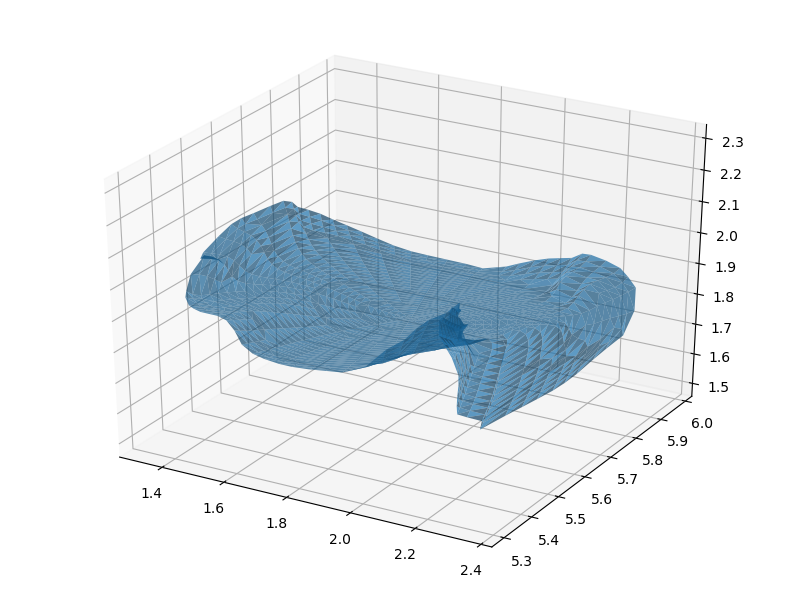

In [359]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(mf.xs,mf.ys,mf.zs,triangles=mf.triangulations,alpha=0.7)
#for p in mf.levelsets[-1].points:
#    ax.scatter(p.pos[0],p.pos[1],p.pos[2])
#s = np.linspace(0,1,1000)
#for l in mf.levelsets[-10:]:
#    pts = np.asarray([l.interpolation(s_) for s_ in s])
#    ax.plot(pts[:,0],pts[:,1],pts[:,2])
#ax.plot_trisurf(verts1[:,0],verts1[:,1],verts1[:,2],color='red')
#ax.plot_trisurf(verts2[:,0],verts2[:,1],verts2[:,2],color='green')
plt.tight_layout()

In [46]:
sv1 = np.array([-0.02952768920617821, 0.007012193247364351, -0.025977427574849])
sv2 = np.array([0.36886301985816833, -0.05413370116128868, 0.31859737945723043])
nm1 = np.array(([0.09871956586378083, 0.885993661112129, -0.09738379419764753]))

In [49]:
sv1.dot(nm1)

0.005827578568996919

In [94]:
verts1 = t1.get_vertices()                                  
verts2 = t2.get_vertices()                                                                       
                                                    

In [48]:
q2 = []

In [49]:
a = Triangle(verts1)

NameError: name 'verts1' is not defined

In [200]:
b = Triangle(verts2)

In [201]:
RayCheckThingamaBob = RayTriangleIntersection(eps=1e-8, culling = True)

In [202]:
intersects(a,b)

Check 1:
origin : [1. 0. 2.]
direction : [2. 0. 0.]
0.0
Check 1:
origin : [1. 0. 2.]
direction : [ 1.  2. -3.]
12.0
********************************************************************************
[ 1.  2. -3.]
[1. 2. 0.]
Cross to
[ 6. -3.  0.]
Check 1:
origin : [3. 0. 2.]
direction : [-1.  2. -3.]
12.0
********************************************************************************
[-1.  2. -3.]
[1. 2. 0.]
Cross to
[ 6. -3. -4.]


True

In [153]:
q2

[array([1.66666667, 0.66666667, 0.        ])]

In [129]:
pv1 = verts1[1]-np.asarray(q2)
pv2 = verts1[2]-np.asarray(q2)

In [130]:
pv1

array([[ 0.5, -1. ,  0. ]])

In [133]:
#pv1[1][0]

In [134]:
#pv1.dot(nm1)

In [135]:
#pv2.dot(nm1)

<IPython.core.display.Javascript object>


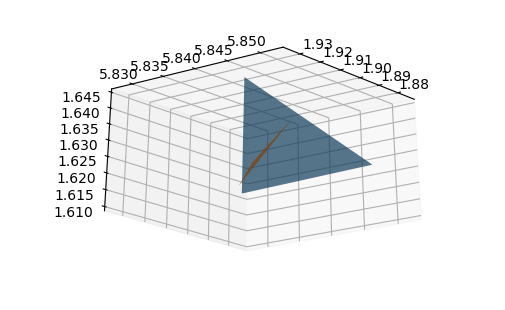

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(verts1[:,0],verts1[:,1],verts1[:,2],alpha=0.7)
ax.plot_trisurf(verts2[:,0],verts2[:,1],verts2[:,2],alpha=0.7)
#ax.quiver(verts1[0,0],verts1[0,1],verts1[0,2],pv1[0][0],pv1[0][1],pv1[0][2])
#ax.quiver(verts1[0,0],verts1[0,1],verts1[0,2],sv2[0],sv2[1],sv2[2])
#ax.quiver(verts2[0,0],verts2[0,1],verts2[0,2],nm1[0],nm1[1],nm1[2])
#ax.scatter(np.asarray(q2)[:,0],np.asarray(q2)[:,1],np.asarray(q2)[:,2])


In [ ]:
%lprun -f RayTriangleIntersection.__call__ mf.add_level_sets(1)

In [466]:
start = time.time()
mf.add_level_sets(50)
print(time.time() - start)

GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   33 completed. Number of points:   80. Cumulative geodesic distance: 0.660. Elapsed time: 1.37 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   34 completed. Number of points:   80. Cumulative geodesic distance: 0.680. Elapsed time: 1.31 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   35 completed. Number of points:   80. Cumulative geodesic distance: 0.700. Elapsed time: 1.38 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   36 completed. Number of points:   80. Cumulative geodesic distance: 0.720. Elapsed time: 1.59 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current require

KeyboardInterrupt: 

In [ ]:
%lprun -f Manifold.self_intersections mf.add_level_sets(1)

In [ ]:
#%lprun -f GeodesicLevelSet._revise_set mf.add_level_sets(1)

In [46]:
#mf.set_xyzs()
mf.compute_lambda3_and_weights()

Point weights identified.


<IPython.core.display.Javascript object>


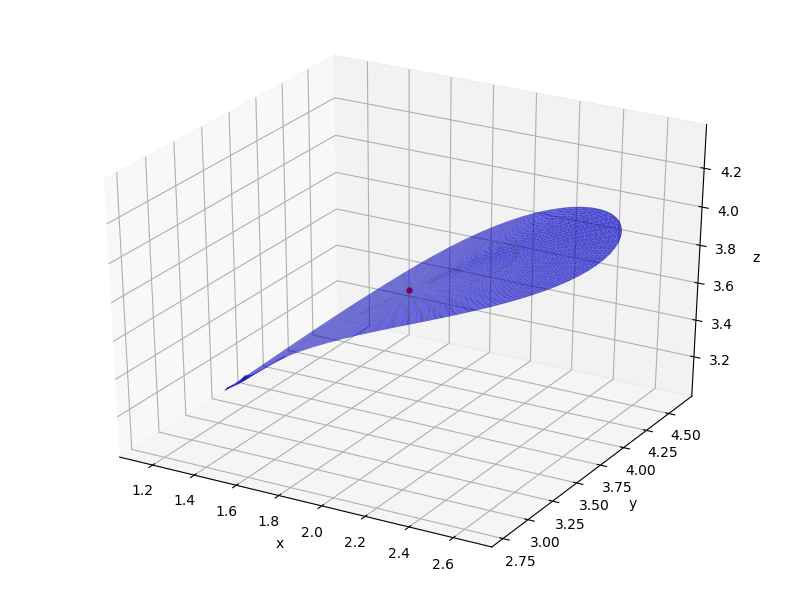

In [49]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(mf.xs, mf.ys, mf.zs, color = 'b', triangles = mf.triangulations, alpha=0.7)
#ax.plot_surface(np.meshgrid(x,y, indexing = 'ij')[0], np.meshgrid(x,y, indexing = 'ij')[1], 
#        np.sin(2*np.meshgrid(x,y, indexing = 'ij')[0])*np.sin(2*np.meshgrid(x,y, indexing = 'ij')[1]) + np.pi,
#        color = 'r', alpha = 0.5)
#for (ps_sq, s) in zip(ps,strs):
#    ax.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s,alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)

ax.scatter(init_pos[0],init_pos[1],init_pos[2],s=12,c='red')

plt.tight_layout()

In [135]:
mf.geo_dist

0.9400000000000005

In [291]:
a = mf.triangles[2]
b = mf.triangles[0]

In [292]:
intersects(a,b)

False

In [182]:
len(mf.triangulations)

1820

In [62]:
s = np.linspace(0,1,1000)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

#x.scatter(0,0,0)

for l in mf.levelsets[:1]:
    for p in l.points:
        ax.scatter(p.pos[0],p.pos[1],p.pos[2])
        v = field(0,p.pos)
        ax.quiver3D(p.pos[0],p.pos[1],p.pos[2],v[0],v[1],v[2],color='tomato',length=0.001)
        ax.quiver3D(p.pos[0],p.pos[1],p.pos[2],p.tan_vec[0],p.tan_vec[1],p.tan_vec[2],color='steelblue',length=0.001)

for l in mf.levelsets[1:2]:
    #pts = np.asarray([l.interpolation(s_) for s_ in s])
    #ax.plot(pts[...,0],pts[...,1],pts[...,2])
    for p in l.points:
        #x.scatter(p.pos[0],p.pos[1],p.pos[2])
        ax.quiver3D(p.pos[0]-p.prev_vec[0],p.pos[1]-p.prev_vec[1],p.pos[2]-p.prev_vec[2],p.prev_vec[0],p.prev_vec[1],p.prev_vec[2],color='cyan',length=0.1)
        #ax.quiver3D(p.pos[0],p.pos[1],p.pos[2],p.tan_vec[0],p.tan_vec[1],p.tan_vec[2],length=dist,color='tomato')

#ax.plot(q[...,0],q[...,1],q[...,2])

#ax.plot_trisurf(mf.xs, mf.ys, mf.zs, color = 'b', triangles = mf.triangulations, alpha=0.7)
#ax.plot_surface(np.meshgrid(x,y, indexing = 'ij')[0], np.meshgrid(x,y, indexing = 'ij')[1], 
#        np.sin(2*np.meshgrid(x,y, indexing = 'ij')[0])*np.sin(2*np.meshgrid(x,y, indexing = 'ij')[1]) + np.pi,
#        color = 'r', alpha = 0.5)
#for (ps_sq, s) in zip(ps,strs):
#    ax.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s,alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(-0.4,-0.6)
#ax.set_ylim(-0.4,-0.6)
#ax.set_zlim(-0.4,-0.6)

ax.view_init(90,-145)
plt.tight_layout()

<IPython.core.display.Javascript object>

NameError: name 'field' is not defined

<IPython.core.display.Javascript object>


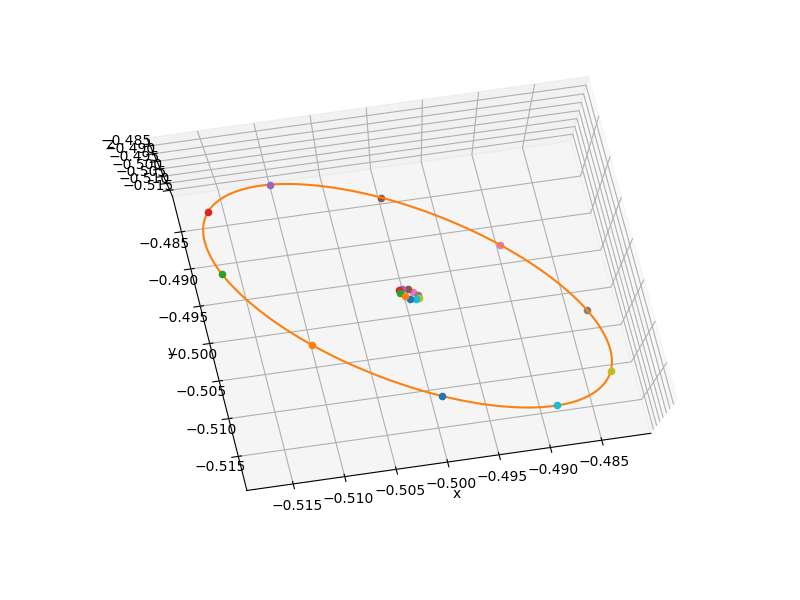

In [65]:
s = np.linspace(0,1,1000)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

for l in mf.levelsets[:2]:
    for p in l.points:
        ax.scatter(p.pos[0],p.pos[1],p.pos[2])

        
#ax.plot(q[...,0],q[...,1],q[...,2])
for l in mf.levelsets[:2]:
    pts = np.asarray([l.interpolation(s_) for s_ in s])
    ax.plot(pts[...,0],pts[...,1],pts[...,2])
#    for p in l.points:
#        ax.scatter(p.pos[0],p.pos[1],p.pos[2])
#        ax.quiver3D(p.pos[0]-p.prev_vec[0],p.pos[1]-p.prev_vec[1],p.pos[2]-p.prev_vec[2],p.prev_vec[0],p.prev_vec[1],p.prev_vec[2],length=100*max_sep)
        #ax.quiver3D(p.pos[0],p.pos[1],p.pos[2],p.tan_vec[0],p.tan_vec[1],p.tan_vec[2],length=dist,color='tomato')

#ax.plot(q[...,0],q[...,1],q[...,2])

#ax.plot_trisurf(mf.xs, mf.ys, mf.zs, color = 'b', triangles = mf.triangulations, alpha=0.7)
#ax.plot_surface(np.meshgrid(x,y, indexing = 'ij')[0], np.meshgrid(x,y, indexing = 'ij')[1], 
#        np.sin(2*np.meshgrid(x,y, indexing = 'ij')[0])*np.sin(2*np.meshgrid(x,y, indexing = 'ij')[1]) + np.pi,
#        color = 'r', alpha = 0.5)
#for (ps_sq, s) in zip(ps,strs):
#    ax.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s,alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(-0.4,-0.6)
#ax.set_ylim(-0.4,-0.6)
#ax.set_zlim(-0.4,-0.6)

ax.view_init(90,-145)
plt.tight_layout()

In [174]:
np.linalg.norm(q[-1] - q[0])

0.02799484797619519

In [97]:
direction_generator(0,init_pos)

array([ 0.81465399, -0.454805  , -0.35984899])

In [98]:
init_pos

array([0.5, 0.5, 0.5])

In [353]:
djangofoo = LCSCandidate(mf)

In [354]:
mf.input_params.init_pos

array([1.88495559, 5.598878  , 1.84799568])

In [355]:
djangofoo.points[0].pos

array([1.88495559, 5.598878  , 1.84799568])

In [356]:
djangofoo.tot_weight

3.836796339728063

<IPython.core.display.Javascript object>


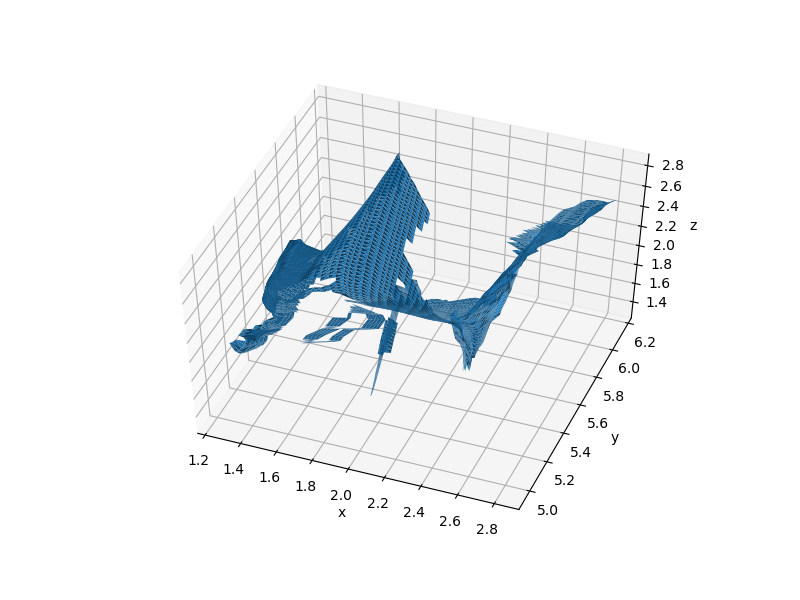

Text(0.5,0,'z')

In [357]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

#s = np.linspace(0,1,1000)

ax.plot_trisurf(djangofoo.xs,djangofoo.ys,djangofoo.zs,triangles=djangofoo.triangulations)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#for l in mf.levelsets[:]:
#    for p in l.points:
#        if p.in_ab:
#            ax.scatter(p.pos[0],p.pos[1],p.pos[2],c='r')
#        else:
#            ax.scatter(p.pos[0],p.pos[1],p.pos[2],c='k')
    #pts = np.asarray([l.interpolation(s_) for s_ in s])
    #ax.plot(pts[...,0],pts[...,1],pts[...,2])
    #for p in l.points:
    #    ax.scatter(p.pos[0],p.pos[1],p.pos[2])
    

<IPython.core.display.Javascript object>


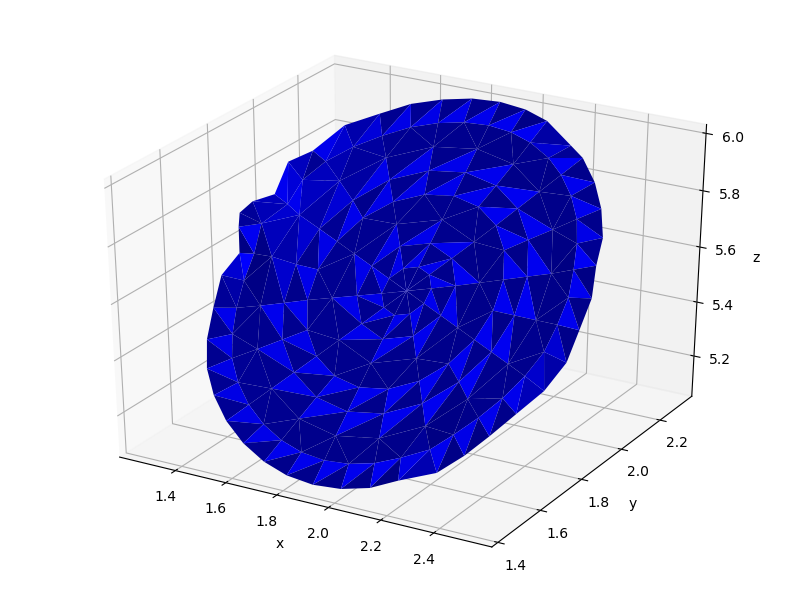

In [89]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(mf.xs, mf.ys, mf.zs, color = 'b', triangles = mf.triangulations)
#ax.plot_surface(np.meshgrid(x,y, indexing = 'ij')[0], np.meshgrid(x,y, indexing = 'ij')[1], 
#        0.5*np.sin(2*np.meshgrid(x,y, indexing = 'ij')[0])*np.sin(2*np.meshgrid(x,y, indexing = 'ij')[1]) + np.pi,
#        color = 'r', alpha = 0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)

plt.tight_layout()

In [65]:
mf.compute_lambda3_and_weights()
mf.check_ab()

LCS_cand = LCSCandidate(mf)

Point weights identified.
Points in AB domain identified.


<IPython.core.display.Javascript object>


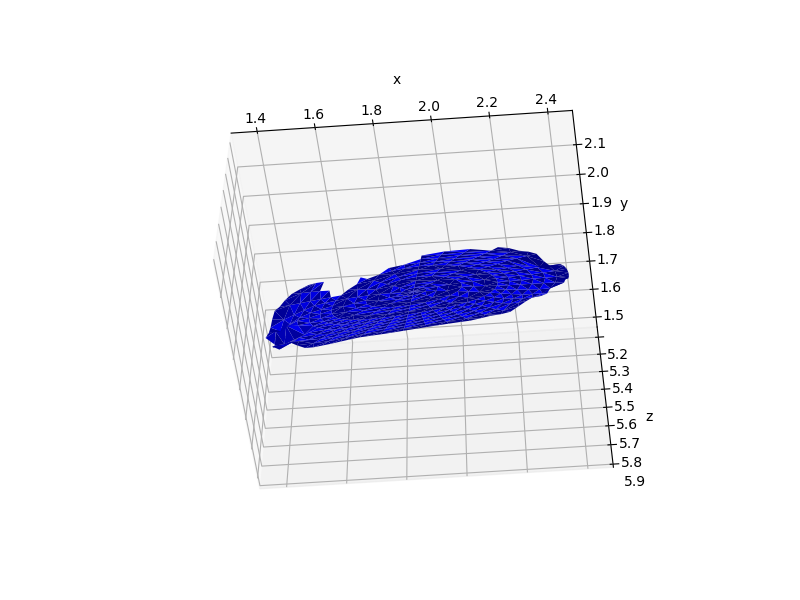

In [66]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(LCS_cand.xs, LCS_cand.ys, LCS_cand.zs, color = 'b', triangles = LCS_cand.triangulations)
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Trajectory verification 

In [105]:
xi1_itp_bspline = SplineEigenvectorInterpolator(x,y,z,xi1)
xi2_itp_bspline = SplineEigenvectorInterpolator(x,y,z,xi2)
xi3_field_bspline = SplineEigenvectorInterpolator(x,y,z,xi3)

In [138]:
class RHS_ODEtrajectory:
    def __init__(self):
        pass
    def set_tan_vec(self,a,pm,init_pos):
        self.tan_vec = a*xi1_itp_bspline(init_pos) + pm*np.sqrt(1-a**2)*xi2_itp_bspline(init_pos)
    def set_prev_vec(self,v):
        self.prev_vec = v
    def __call__(self, t, x):
        v = cy_cross_product(self.tan_vec,xi3_field_bspline(x))
        if cy_dot(v,self.prev_vec) < 0:
            v = -v
        return cy_normalize(v)

In [139]:
def generate_trajectories(init_pos, t0, tf, h):
    _a = (np.arange(201)-100)/100
    _pm = [1,-1]
    
    func = RHS_ODEtrajectory()
    

    _p = []
    
    _strs = []
    
    for a in _a:
        for pm in _pm:
            func.set_tan_vec(a,pm,init_pos)
            func.set_prev_vec(cy_cross_product(func.tan_vec,xi3_field_bspline(init_pos)))
            t = t0
            ps = [init_pos]
            _h = h
            p = ps[0]
            while t < tf:
                _h = min(_h,tf-t)
                v = func(t,p)
                t,p,_h = rk4(t,p,_h,func)
                func.set_prev_vec(v)
                ps.append(p)
            _p.append(np.asarray(ps))
            _strs.append('{:.3f}xi1{}{:.3f}xi2'.format(a,'+' if pm == 1 else '-',np.sqrt(1-a**2)))
    return _p, _strs

class RHS_ODEtrajectory:
    def __init__(self):
        pass
    
    def set_a(self,a):
        self.a = a
        self.b = np.sqrt(1-a**2)
    
    def set_pm(self,pm):
        self.pm = pm
        
    def __call__(self,t,x):
        return self.a*xi1_itp_bspline(x)+self.pm*self.b*xi2_itp_bspline(x)

def generate_trajectories(init_pos, t0, tf, h):
    _a = (np.arange(201)-100)/100
    _pm = [1,-1]
    
    func = RHS_ODEtrajectory()
    

    _p = []
    
    _strs = []
    
    for a in _a:

        func.set_a(a)

        for pm in _pm:
            func.set_pm(pm)
            t = t0
            ps = [init_pos]
            _h = h
            p = ps[0]
            
            while t < tf:
                _h = min(_h,tf-t)
                t,p,_h = rk4(t,p,_h,func)
                ps.append(p)
            
            _p.append(np.asarray(ps))
            _strs.append('{:.3f}xi1{}{:.3f}xi2'.format(func.a,'+' if pm == 1 else '-',func.b))
            
    return _p, _strs

In [142]:
ps,strs = generate_trajectories(init_pos, 0, 1.8, 0.01)
ps = np.asarray(ps)

In [143]:
cy_parallel_component?

<IPython.core.display.Javascript object>


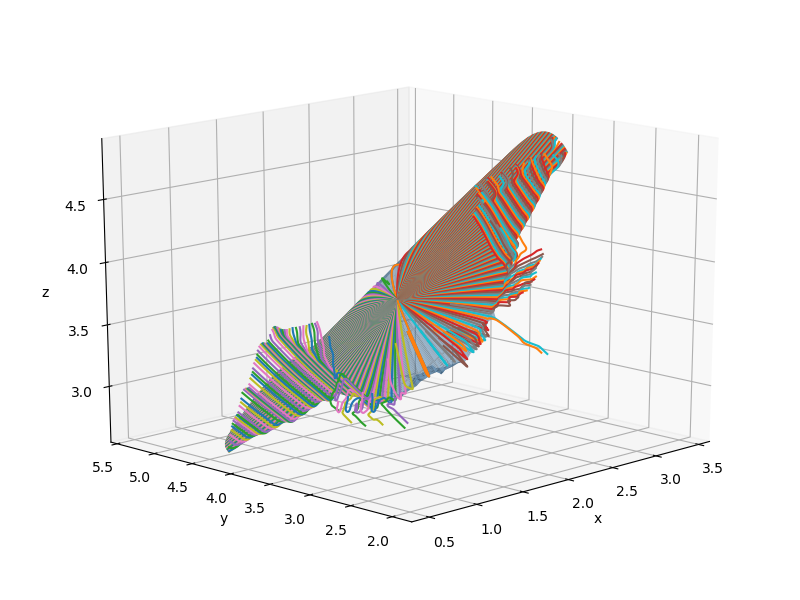

In [144]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf(mf.xs, mf.ys, mf.zs, color = 'steelblue', triangles = mf.triangulations,alpha=0.55)
#ax.quiver3D(xs[::10],ys[::10],zs[::10],qvarrs[...,0],qvarrs[...,1],qvarrs[...,2],length=0.2)
for (ps_sq, s) in zip(ps,strs):
    ax.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(5.2,5.7)
#ax.set_ylim(3.5,3.8)
#ax.set_zlim(3.2,3.8)
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)
#ax.legend()
plt.tight_layout()

# Several manifolds stacked for LCS comparison

In [42]:
Ncores = 9

In [43]:
initial_positions = compute_manifold_initial_positions(compute_hessian_lm(lm3,dx,dy,dz),lm3,lm2,xi3,20)
dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
if sinusoidalsurface:
    initial_positions = np.array([(np.pi,np.pi,_z) for _z in np.linspace(1,2*np.pi-1,int(Ncores/3))])
if bucketshell:
    initial_positions = np.array([(_x, 0, 0) for _x in np.linspace(1/np.sqrt(2)-0.2,1/np.sqrt(2)+0.2,int(Ncores/3))])
    dom_bound = np.array((-2,2,-2,2,-2,2))

In [44]:
#Ncores = 3

eps = 0.01

init_pos = np.empty((Ncores,3))

for i in range(Ncores):
    if (np.divmod(i,3)[1] == 0):
        init_pos[i] = initial_positions[int(i/3)]
    elif (np.divmod(i,3)[1] == 1):
        init_pos[i] = initial_positions[int(i/3)] - eps*xi3_field(initial_positions[int(i/3)])
    else:
        init_pos[i] = initial_positions[int(i/3)] + eps*xi3_field(initial_positions[int(i/3)])
        
max_geo_dist = 6#np.pi
min_s_step = 0.0001
max_s_step = 0.01
dist_tol = 0.005
plane_tol = 0.005
tan_tol = 0.1
min_ang = 10*np.pi/180
max_ang = 20*np.pi/180
min_sep = 0.05
max_sep = 0.2
dist = min_sep*2
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2
prev_vec_tol = 0.1
max_dist_tol = 0.2
max_plane_tol = 0.2
max_arclen_factor = 3
init_num_points = 10
init_radius = 1e-3

In [45]:
init_pos

array([[3.14159265, 3.14159265, 1.        ],
       [3.14159265, 3.14159265, 1.01      ],
       [3.14159265, 3.14159265, 0.99      ],
       [3.14159265, 3.14159265, 3.14159265],
       [3.14159265, 3.14159265, 3.15159265],
       [3.14159265, 3.14159265, 3.13159265],
       [3.14159265, 3.14159265, 5.28318531],
       [3.14159265, 3.14159265, 5.29318531],
       [3.14159265, 3.14159265, 5.27318531]])

In [46]:
def lcs_selection(mfs):
    
    mfs_mn = []
    mfs_up = []
    mfs_dn = []
    
    [mf.check_ab() for mf in mfs]
    [mf.compute_lambda3_and_weights() for mf in mfs]
    
    for i in range(len(mfs)):
        if (np.divmod(i,3)[1] == 0):
            mfs_mn.append(mfs[i])
        elif(np.divmod(i,3)[1] == 1):
            mfs_up.append(mfs[i])
        else:
            mfs_dn.append(mfs[i])
    
    ls = []

    for outer in zip(mfs_mn, mfs_up, mfs_dn):
        for mf in outer:
            mf.check_ab()
            mf.compute_lambda3_and_weights()

    LCS_m = [LCSCandidate(mf) for mf in mfs_mn]
    LCS_u = [LCSCandidate(mf) for mf in mfs_up]
    LCS_d = [LCSCandidate(mf) for mf in mfs_dn]
    
    for (m,u,d) in zip(LCS_m,LCS_u,LCS_d):
        print('m',m.avg_lambda3)
        print('u',u.avg_lambda3)
        print('d',d.avg_lambda3)

    for i in range(len(LCS_m)):
        if(LCS_m[i].avg_lambda3 > max(LCS_u[i].avg_lambda3,LCS_d[i].avg_lambda3) and LCS_m[i].tot_weight > 0):
            ls.append(LCS_m[i])

    return ls

In [59]:
###################### Functions for running manifold development in parallel ########################

def foo(init_pos, num_sets_to_add, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol,
            tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep, prev_vec_tol, max_dist_tol,
            max_plane_tol, max_arclen_factor, init_num_points, init_radius, q
       ):
    mf = (Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep,prev_vec_tol,
                      max_dist_tol,max_plane_tol,max_arclen_factor, init_num_points, init_radius))
    mf.add_level_sets(num_sets_to_add)
    # Can't pickle c_class objects -> Delete here, create again when collecting from queue
    for l in mf.levelsets:
        del l.interpolation
    del mf.triangles
    q.put(mf)
    

def bar():
    qs = [mp.Queue() for j in range(Ncores)]
    ps = [mp.Process(target = foo,
                    args = (init_pos[j], 50,
                            dom_bound,
                            max_geo_dist,
                            min_s_step,
                            max_s_step,
                            dist,
                            dist_tol, 
                            plane_tol,
                            tan_tol, 
                            min_ang, 
                            max_ang, 
                            min_dist_ang,
                            max_dist_ang, 
                            min_sep,
                            max_sep,
                            prev_vec_tol,
                            max_dist_tol, 
                            max_plane_tol,
                            max_arclen_factor, init_num_points, init_radius,
                            qs[j]
                           )
                    ) for j in range(Ncores)]

    mfs = []

    [p.start() for p in ps]

    for j, q in enumerate(qs):
        mfs.append(q.get())
        # Add c_class interpolation object in local namespace, as it can't be pickled
        #for l in mfs[j].levelsets:
        #    l.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in l.points]),
        #                                                 wraparound=True,pad_points=2)

    [p.join() for p in ps]

    return mfs

In [60]:
start = time.time()
mfs = bar()
print('Time spent:', time.time()-start)

GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Level set    2 completed. Number of points:   10. Cumulative geodesic distance: 0.100. Elapsed time: 0.01 seconds.
GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Level set    3 completed. Number of points:   10. Cumulative geodesic distance: 0.150. Elapsed time: 0.01 seconds.
GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
Level set    2 completed. Number of points:   10. Cumulative geodesic distance: 0.100. Elapsed time: 0.03 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Geode

Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Level set    6 completed. Number of points:   10. Cumulative geodesic distance: 0.300. Elapsed time: 0.03 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    6 completed. Number of points:   10. Cumulative geodesic distance: 0.300. Elapsed time: 0.05 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Level set   

GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    9 completed. Number of points:   20. Cumulative geodesic distance: 0.450. Elapsed time: 0.13 seconds.
GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set    9 completed. Number of points:   20. Cumulative geodesic distance: 0.450. Elapsed time: 0.12 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   10 completed. Number of points:  

Smaller step than min_sep required with current requirements. Continuing anyway
Level set   13 completed. Number of points:   28. Cumulative geodesic distance: 0.650. Elapsed time: 0.47 seconds.
GeodesicLevelSet.__init__ called
Level set   13 completed. Number of points:   28. Cumulative geodesic distance: 0.650. Elapsed time: 0.39 seconds.
Level set   13 completed. Number of points:   28. Cumulative geodesic distance: 0.650. Elapsed time: 0.37 seconds.
GeodesicLevelSet.__init__ called
Level set   14 completed. Number of points:   37. Cumulative geodesic distance: 0.700. Elapsed time: 0.26 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   13 completed. Number of points:   28. Cumulative geodesic distance: 0.650. E

Level set   17 completed. Number of points:   52. Cumulative geodesic distance: 0.850. Elapsed time: 0.95 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   17 completed. Number of points:   52. Cumulative geodesic distance: 0.850. Elapsed time: 0.94 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   17 completed. Number of points:   52. Cumulative geodesic distance: 0.850. Elapsed time: 1.12 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   18 completed. Number of points:   52. Cumulative geodesic distance: 0.900. Elapsed time: 1.03 seconds.
Level set   17 completed. Number of points:   52. Cumulative geodesic distance: 0.850. Elapsed time: 0.87 seconds.
Geodes

Level set   21 completed. Number of points:   56. Cumulative geodesic distance: 1.050. Elapsed time: 1.73 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   21 completed. Number of points:   56. Cumulative geodesic distance: 1.050. Elapsed time: 1.60 seconds.
GeodesicLevelSet.__init__ called
Level set   21 completed. Number of points:   56. Cumulative geodesic distance: 1.050. Elapsed time: 1.52 seconds.
Smaller step than min_sep required with current requirements. Continuing anyway
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   21 completed. Number of points:   56. Cumulative geodesic distance: 1.050. Elapsed time: 1.59 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level se

Smaller step than min_sep required with current requirements. Continuing anyway
Level set   25 completed. Number of points:   64. Cumulative geodesic distance: 1.250. Elapsed time: 2.63 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   25 completed. Number of points:   64. Cumulative geodesic distance: 1.250. Elapsed time: 3.02 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   25 completed. Number of points:   64. Cumulative geodesic distance: 1.250. Elapsed time: 2.26 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   25 completed. Number of points:   64. Cumulative geodesic distance: 1.250. Elapsed time: 3.27 seconds.
GeodesicLevelSet.__init__ called
Level set   25 completed. Number of points:   64. Cumulative geodesic distance: 1.250. E

Smaller step than min_sep required with current requirements. Continuing anyway
Level set   29 completed. Number of points:   76. Cumulative geodesic distance: 1.450. Elapsed time: 3.74 seconds.
GeodesicLevelSet.__init__ called
Level set   29 completed. Number of points:   76. Cumulative geodesic distance: 1.450. Elapsed time: 3.72 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   29 completed. Number of points:   76. Cumulative geodesic distance: 1.450. Elapsed time: 3.79 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   29 completed. Number of points:   76. Cumulative geodesic distance: 1.450. Elapsed time: 3.74 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level se

Smaller step than min_sep required with current requirements. Continuing anyway
Level set   33 completed. Number of points:   92. Cumulative geodesic distance: 1.650. Elapsed time: 5.80 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   33 completed. Number of points:   92. Cumulative geodesic distance: 1.650. Elapsed time: 6.37 seconds.
GeodesicLevelSet.__init__ called
Level set   33 completed. Number of points:   92. Cumulative geodesic distance: 1.650. Elapsed time: 5.45 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   33 completed. Number of points:   92. Cumulative geodesic distance: 1.650. Elapsed time: 6.44 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level se

Smaller step than min_sep required with current requirements. Continuing anyway
Level set   37 completed. Number of points:   96. Cumulative geodesic distance: 1.850. Elapsed time: 8.68 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   37 completed. Number of points:   96. Cumulative geodesic distance: 1.850. Elapsed time: 8.08 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   37 completed. Number of points:   96. Cumulative geodesic distance: 1.850. Elapsed time: 7.89 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   37 completed. Number of points:   96. Cumulative geodesic distance: 1.850. Elapsed time: 8.20 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level se

GeodesicLevelSet.__init__ called
GeodesicLevelSet.__init__ called
Level set   41 completed. Number of points:  104. Cumulative geodesic distance: 2.050. Elapsed time: 10.59 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   41 completed. Number of points:  104. Cumulative geodesic distance: 2.050. Elapsed time: 11.55 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   41 completed. Number of points:  104. Cumulative geodesic distance: 2.050. Elapsed time: 11.21 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   41 completed. Number of points:  104. Cumulative geodesic distance: 2.050. 

Level set   45 completed. Number of points:  126. Cumulative geodesic distance: 2.250. Elapsed time: 19.18 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   45 completed. Number of points:  126. Cumulative geodesic distance: 2.250. Elapsed time: 18.89 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   45 completed. Number of points:  126. Cumulative geodesic distance: 2.250. Elapsed time: 17.88 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   45 completed. Number of points:  126. Cumulative geodesic distance: 2.250. Elapsed time: 18.45 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   45 completed. Number of points:  126. Cumulative geodesic distance: 2.25

Level set   49 completed. Number of points:  146. Cumulative geodesic distance: 2.450. Elapsed time: 21.91 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   49 completed. Number of points:  146. Cumulative geodesic distance: 2.450. Elapsed time: 23.02 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   49 completed. Number of points:  146. Cumulative geodesic distance: 2.450. Elapsed time: 22.51 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   49 completed. Number of points:  146. Cumulative geodesic distance: 2.450. Elapsed time: 22.77 seconds.
GeodesicLevelSet.__init__ called
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   49 completed. Number of points:  146. Cumulative geodesic distance: 2.45

In [ ]:
mfs

In [ ]:
[mf.set_xyzs() for mf in mfs]
print(' ')

<IPython.core.display.Javascript object>


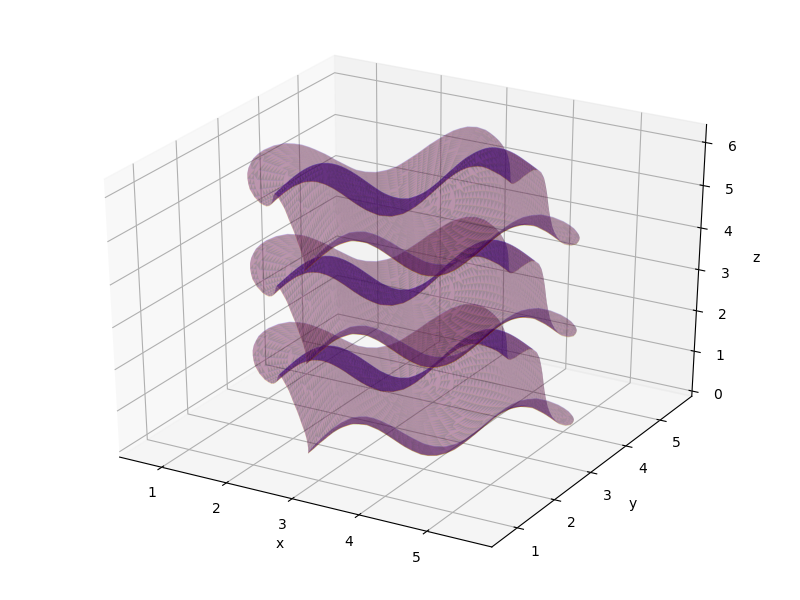

In [61]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

clrs = ['r','b','y']

for i, mf in enumerate(mfs):
    ax.plot_trisurf(mf.xs, mf.ys, mf.zs, triangles = mf.triangulations, alpha = 0.2, color = clrs[divmod(i,3)[1]])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)

plt.tight_layout()

In [65]:
LCSs = lcs_selection(mfs)

Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB domain identified.
Point weights identified.
Points in AB d

In [66]:
LCSs

<IPython.core.display.Javascript object>


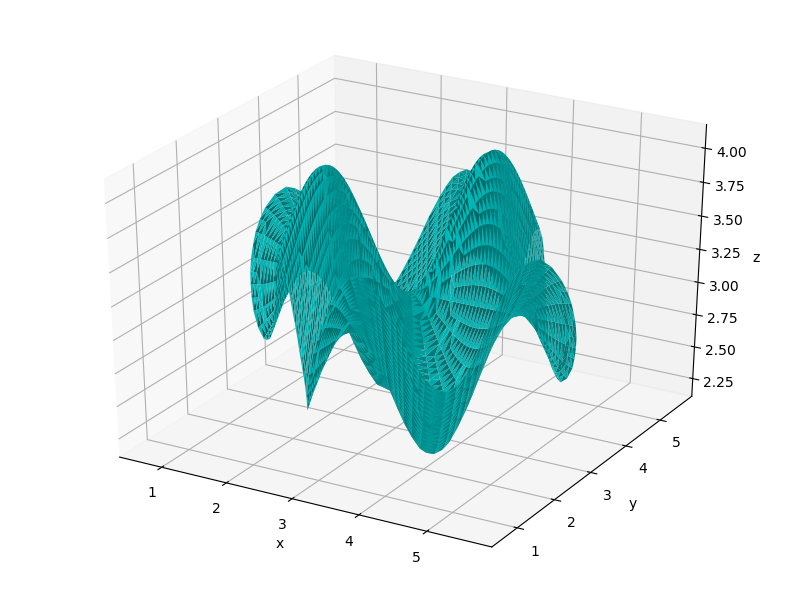

In [67]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

cs = ['r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g',
     'r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g','r','c','y','g']

counter = 0
for LCS in LCSs:
    counter += 1
    ax.plot_trisurf(LCS.xs, LCS.ys, LCS.zs, color = cs[counter], triangles = LCS.triangulations)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)

plt.tight_layout()

# Convergence tests 

In [44]:
init_pos = initial_positions[1]

dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
max_geo_dist = 0.5#np.pi
min_s_step = 0.0001
max_s_step = 0.01
dist_tol = 0.005
plane_tol = 0.005
tan_tol = 0.01
min_ang = 15*np.pi/180
max_ang = 20*np.pi/180
prev_vec_tol = 0.1
max_dist_tol = 0.2
max_plane_tol = 0.2
max_arclen_factor = 3
init_num_points = 10
init_radius = 1e-3

In [45]:
min_sep = 0.01
max_sep = 0.08
dist = min_sep*2
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2

mf_l = (Manifold(initial_positions[3],dom_bound,1.5,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep,prev_vec_tol,
              max_dist_tol,max_plane_tol,max_arclen_factor, init_num_points, init_radius))
start = time.time()
mf_l.add_level_sets(100)
print('Time spent =', time.time() - start)

Level set    2 completed. Number of points:   10. Cumulative geodesic distance: 0.020. Elapsed time: 0.04 seconds.
Level set    3 completed. Number of points:   10. Cumulative geodesic distance: 0.040. Elapsed time: 0.02 seconds.
Level set    4 completed. Number of points:   10. Cumulative geodesic distance: 0.060. Elapsed time: 0.02 seconds.
Level set    5 completed. Number of points:   10. Cumulative geodesic distance: 0.080. Elapsed time: 0.02 seconds.
Level set    6 completed. Number of points:   10. Cumulative geodesic distance: 0.100. Elapsed time: 0.01 seconds.
Level set    7 completed. Number of points:   10. Cumulative geodesic distance: 0.120. Elapsed time: 0.01 seconds.
Level set    8 completed. Number of points:   20. Cumulative geodesic distance: 0.140. Elapsed time: 0.02 seconds.
Level set    9 completed. Number of points:   20. Cumulative geodesic distance: 0.160. Elapsed time: 0.02 seconds.
Level set   10 completed. Number of points:   20. Cumulative geodesic distance: 

Returned poor point after using relaxed acceptance criteria
Returned poor point after using relaxed acceptance criteria
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   50 completed. Number of points:   93. Cumulative geodesic distance: 0.650. Elapsed time: 11.36 seconds.
Returned poor point after using relaxed acceptance criteria
Smaller step than min_sep required with current requirements. Continuing anyway
Returned poor point after using relaxed acceptance criteria
Level set   51 completed. Number of points:   97. Cumulative geodesic distance: 0.660. Elapsed time: 11.29 seconds.
Returned poor point after using relaxed acceptance criteria
Returned poor point after using relaxed acceptance criteria
Smaller step than min_sep required with current requirements. Continuing anyway
Level set   52 completed. Number of points:   98. Cumulative geodesic distance: 0.670. Elapsed time: 9.42 seconds.
Smaller step than min_sep required with current requi

remove_loops did something!
Level set   74 completed. Number of points:  172. Cumulative geodesic distance: 0.890. Elapsed time: 22.36 seconds.


KeyboardInterrupt: 

In [79]:
%lprun -f Point._compute_pos_aim_ mf_l.add_level_sets(1)

Smaller step than min_sep required with current requirements. Continuing anyway
Level set    6 completed. Number of points:   20. Cumulative geodesic distance: 0.400. Elapsed time: 1.24 seconds.
Max geodesic distance reached. No more level sets can be added in the current environment.


In [52]:
min_sep = 0.02
max_sep = 0.08
dist = min_sep
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2

mf_s = (Manifold(initial_positions[3],dom_bound,0.9,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep,prev_vec_tol,
              max_dist_tol,max_plane_tol,max_arclen_factor, init_num_points, init_radius))

start = time.time()
mf_s.add_level_sets(100)
print('Time spent =', time.time() - start)

Level set    2 completed. Number of points:   10. Cumulative geodesic distance: 0.020. Elapsed time: 0.03 seconds.
Level set    3 completed. Number of points:   10. Cumulative geodesic distance: 0.040. Elapsed time: 0.02 seconds.
Level set    4 completed. Number of points:   10. Cumulative geodesic distance: 0.060. Elapsed time: 0.03 seconds.
Level set    5 completed. Number of points:   10. Cumulative geodesic distance: 0.080. Elapsed time: 0.02 seconds.
Level set    6 completed. Number of points:   10. Cumulative geodesic distance: 0.100. Elapsed time: 0.02 seconds.
Level set    7 completed. Number of points:   10. Cumulative geodesic distance: 0.120. Elapsed time: 0.02 seconds.
Level set    8 completed. Number of points:   20. Cumulative geodesic distance: 0.140. Elapsed time: 0.04 seconds.
Level set    9 completed. Number of points:   20. Cumulative geodesic distance: 0.160. Elapsed time: 0.04 seconds.
Level set   10 completed. Number of points:   20. Cumulative geodesic distance: 

remove_loops did something!
Level set   46 completed. Number of points:  158. Cumulative geodesic distance: 0.900. Elapsed time: 36.88 seconds.
Max geodesic distance reached. No more level sets can be added in the current environment.
Time spent = 373.20533776283264


In [53]:
#mf_l.set_xyzs()
mf_s.set_xyzs()

<IPython.core.display.Javascript object>


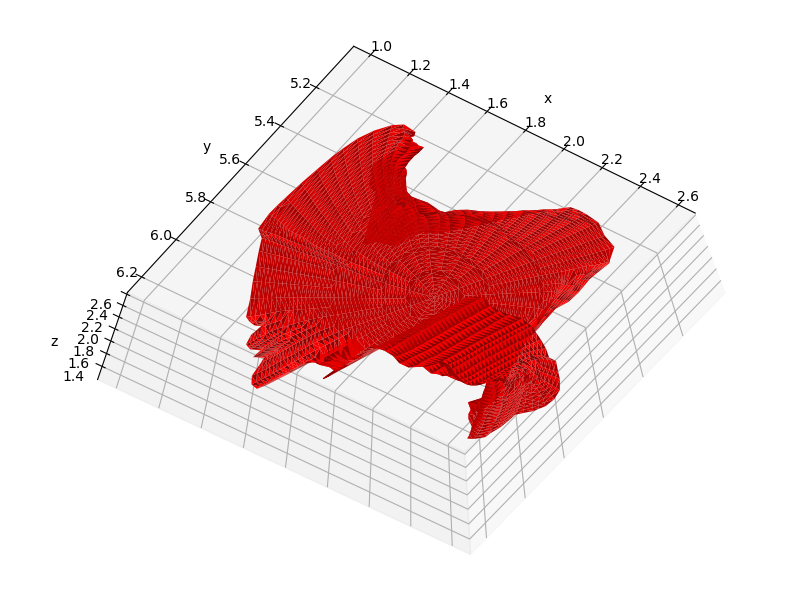

In [54]:
fig = plt.figure(figsize=(8,6))
#ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(111,projection='3d')
#
#ax1.plot_trisurf(mf_l.xs, mf_l.ys, mf_l.zs, color = 'b', triangles = mf_l.triangulations, alpha = 1)
ax2.plot_trisurf(mf_s.xs, mf_s.ys, mf_s.zs, color = 'r', triangles = mf_s.triangulations, alpha = 1)

#for (ps_sq, s) in zip(ps,strs):
#    ax.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s, alpha=0.5)

#ax1.view_init(elev = 0, azim = 300)
ax2.view_init(elev = 0, azim = 300)
#ax1.set_xlabel('x')
#ax1.set_ylabel('y')
#ax1.set_zlabel('z')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
#
#ax2.set_xlim(xmin,xmax)
#ax2.set_ylim(ymin,ymax)
#ax2.set_zlim(zmin,zmax)

plt.tight_layout()

<IPython.core.display.Javascript object>


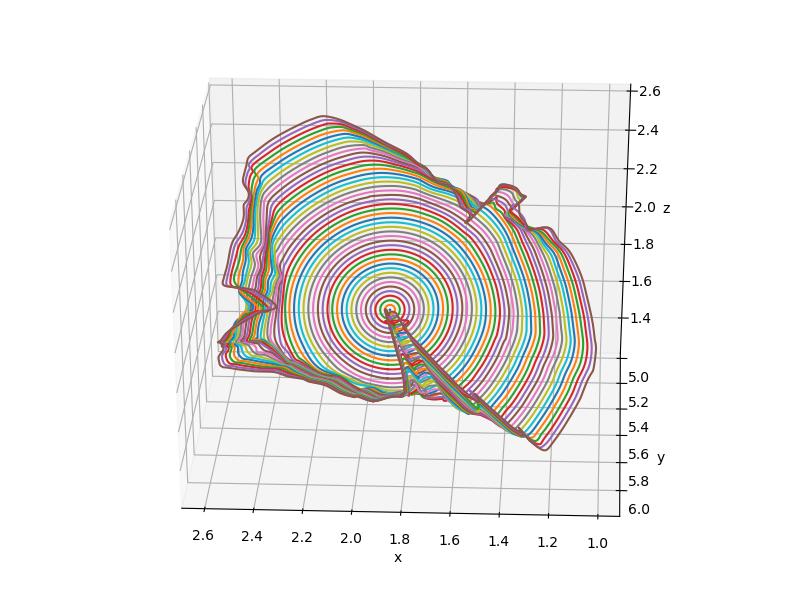

In [49]:
fig = plt.figure(figsize=(8,6))
#ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(111,projection='3d')
#
#ax1.plot_trisurf(mf_l.xs, mf_l.ys, mf_l.zs, color = 'b', triangles = mf_l.triangulations, alpha = 1)
s = np.linspace(0,1,1000)

for l in mf_s.levelsets:
    pts = np.asarray([l.interpolation(s_) for s_ in s]) 
    ax2.plot(pts[:,0], pts[:,1], pts[:,2])

#for (ps_sq, s) in zip(ps,strs):
#    ax.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s, alpha=0.5)

#ax1.view_init(elev = 0, azim = 300)
ax2.view_init(elev = 0, azim = 300)
#ax1.set_xlabel('x')
#ax1.set_ylabel('y')
#ax1.set_zlabel('z')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
#
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)

plt.tight_layout()